<a href="https://colab.research.google.com/github/jleandroforte/Data_Science-Entrega_Final_Forte/blob/main/Entrega_Final_Leandro_Forte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Abstracto**

El dataset con el que vamos a trabajar recopila datos de ventas y actividad de los clientes en el sitio web de una farmacia online a lo largo de 90 días de observaciones.

Tenemos información sobre varias características de los productos que serán detalladas en secciones siguientes, sus precios, los precios de la competencia, y también sobre el comportamiento de los clientes, a saber, si hacen click en un producto, si los colocan en una canasta de productos y finalmente si compran un producto. Nótese que no todas las líneas del dataset representan ventas.

Finalmente, una vez que se produce una venta, tenemos un ingreso monetario, "revenue", que constituirá nuestra variable objetivo a lo largo de la mayor parte del trabajo, con excepciòn del apéndice final, en el cual vamos a explorar también la posibilidad de predecir ventas, lo cual requeriría la aplicación de modelos de clasificación.

Una clave del dataset es que la farmacia sigue una política de 'pricing dinámico' donde los precios de cada producto son ajustados diariamente, dentro de ciertas bandas. Es decir, los productos no tienen un precio constante a lo largo de los 90 días de observaciones, sino que presentan pequeñas variaciones diarias.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Objetivos y contexto comercial**


Para entender el contexto comercial, imaginemos que trabajamos en el departamento de finanzas de la farmacia y necesitamos planificar adecuadamente los ingresos en períodos futuros, lo cual es un insumo fundamental a la hora de prever el resultado financiero del período siguiente.

Nuestra variable objetivo o dependiente será entonces el revenue. El revenue representa la cantidad vendida (que no observamos) multiplicada por el precio, que sí está explicitado en el dataset y es objeto de ajustes diarios.

En función de lo anterior, el objetivo general del trabajo es desarollar modelos para obtener **la mejor predicción posible** de la variable revenue, dados los valores de las restantes variables del dataset, que se tomarán como variables explicativas. La variable clave que cambia con frecuencia diaria es el precio de cada producto.

Entonces, si en períodos futuros nos enfrentamos a un determinado vector de precios, junto con otras características de los productos que también presentan varibilidad, en función del mismo y de las restantes variables explicativas, vamos a poder predecir nuestro revenue.

#**Modelos a usar**

En este trabajo (exceptuando el apéndice) vamos a proponer distintos modelos de regresión para predecir la variable revenue, ajustando sus hiperparámetros y haciendo cross-validation para mejorar la predicción.

Para entender esta elección, tomemos en cuenta que:

> 1. Nuestros datos están etiquetados. En principio, no tenemos la necesidad de hacer un análisis no supervisado.

> 2. La variable independiente es el revenue, o ingresos que generan las ventas (no todas las líneas representan ventas, por tanto, el revenue es 0 en muchas líneas), es una variable numérica continua.

Dicho esto, el trabajo contiene un apéndice donde se explora la alternativa de aplicar un modelo de clasificación para predecir ventas, es decir, si una observación redunda en una compra de parte del cliente,

#**Importación y descripción de la base de datos**


In [ ]:
# Importamos las liberías necesarias.
from google.colab import drive
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
import xgboost as xgb



from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score



drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Entregas/DB'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Entregas/DB


In [ ]:
# nuestro dataset se compone de 3 archivos csv con separador "|", en lugar de comas.
# importamos los archivos y los combinamos en un solo dataset llamado 'farmacia' a través de la variable product id que está presente en los 3 archivos.

pricing_class=pd.read_csv("class.csv", sep='|')
pricing_items=pd.read_csv('items.csv', sep='|')
pricing_train=pd.read_csv('train.csv', sep='|')

dataset = pd.merge(pricing_train, pricing_items, on='pid');
farmacia=pd.DataFrame(dataset)

In [ ]:
farmacia

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
0,1,1,6570,0,2,14.60,1,0,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
1,20746,2,6570,0,2,14.60,0,1,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
2,35477,2,6570,0,2,14.60,1,0,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
3,61647,4,6570,0,2,14.60,1,0,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
4,87130,5,6570,0,2,14.60,0,1,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,2712203,91,20700,0,2,NaN,0,0,1,5.91,...,753,10OK0F,250,G,TEE,0,52,NaN,NaN,6.22
2755999,2713825,91,12000,0,2,NaN,1,0,0,13.01,...,811,20OHG,1,ST,BAN,0,53,NaN,NaN,13.70
2756000,2714766,91,10485,0,2,2.43,1,0,0,2.87,...,61,21OS1,60,G,TEE,0,52,1.0,NaN,3.03
2756001,2718999,91,15158,0,2,3.69,1,0,0,4.77,...,811,20OI2,1,ST,BAN,0,53,NaN,NaN,4.14


In [ ]:
farmacia.shape

(2756003, 21)

Tenemos 21 features y 2.756 millones de observaciones.

In [ ]:
farmacia.info() #La mayoría de nuestras variables son numéricas y categóricas, pero vamos a pronponer un tratamiento para las variables object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756003 entries, 0 to 2756002
Data columns (total 21 columns):
 #   Column           Dtype  
---  ------           -----  
 0   lineID           int64  
 1   day              int64  
 2   pid              int64  
 3   adFlag           int64  
 4   availability     int64  
 5   competitorPrice  float64
 6   click            int64  
 7   basket           int64  
 8   order            int64  
 9   price            float64
 10  revenue          float64
 11  manufacturer     int64  
 12  group            object 
 13  content          object 
 14  unit             object 
 15  pharmForm        object 
 16  genericProduct   int64  
 17  salesIndex       int64  
 18  category         float64
 19  campaignIndex    object 
 20  rrp              float64
dtypes: float64(5), int64(11), object(5)
memory usage: 441.6+ MB


In [ ]:
farmacia.describe(include='all')

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
count,2.756003e+06,2.756003e+06,2.756003e+06,2.756003e+06,2.756003e+06,2.655316e+06,2.756003e+06,2.756003e+06,2.756003e+06,2.756003e+06,...,2.756003e+06,2756003,2756003,2756003,2561879,2.756003e+06,2.756003e+06,2.668609e+06,468035,2.756003e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,533,548,8,278,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,22OI3,50,ST,TAB,NaN,NaN,NaN,B,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,159787,380869,1332256,252906,NaN,NaN,NaN,251965,NaN
mean,1.378002e+06,4.992118e+01,1.044790e+04,3.177888e-01,1.111035e+00,1.277288e+01,5.743198e-01,1.698423e-01,2.558379e-01,1.385008e+01,...,1.744467e+02,NaN,NaN,NaN,NaN,1.055086e-01,4.624467e+01,1.154272e+02,NaN,1.830907e+01
std,7.955897e+05,2.529451e+01,6.456013e+03,4.656170e-01,3.921785e-01,1.275295e+01,4.944458e-01,3.754943e-01,4.363312e-01,1.362307e+01,...,1.873093e+02,NaN,NaN,NaN,NaN,3.072077e-01,6.422195e+00,9.368947e+01,NaN,1.866168e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e-02,...,1.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00,4.000000e+01,1.000000e+00,NaN,7.000000e-02
25%,6.890015e+05,3.100000e+01,4.313000e+03,0.000000e+00,1.000000e+00,5.480000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,...,5.600000e+01,NaN,NaN,NaN,NaN,0.000000e+00,4.000000e+01,4.600000e+01,NaN,7.980000e+00
50%,1.378002e+06,5.000000e+01,1.007700e+04,0.000000e+00,1.000000e+00,8.990000e+00,1.000000e+00,0.000000e+00,0.000000e+00,9.850000e+00,...,1.040000e+02,NaN,NaN,NaN,NaN,0.000000e+00,4.000000e+01,9.200000e+01,NaN,1.317000e+01
75%,2.067002e+06,7.100000e+01,1.614400e+04,1.000000e+00,1.000000e+00,1.506000e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.645000e+01,...,2.200000e+02,NaN,NaN,NaN,NaN,0.000000e+00,5.300000e+01,1.520000e+02,NaN,2.195000e+01


In [ ]:
farmacia.dtypes #tipos de datos. Más adelante se hará el tratamiento de variables no numéricas para poder utilizarla en un modelo de regresión.

lineID               int64
day                  int64
pid                  int64
adFlag               int64
availability         int64
competitorPrice    float64
click                int64
basket               int64
order                int64
price              float64
revenue            float64
manufacturer         int64
group               object
content             object
unit                object
pharmForm           object
genericProduct       int64
salesIndex           int64
category           float64
campaignIndex       object
rrp                float64
dtype: object

#**Descripción de las variables**

**Vamos a proceder a describir verbalmente nuestras variables, cuando se trate de variables que no varían en el tiempo, se explicita en la descripción**

>**day**: el día que se registra, recordemos que tenemos datos 91 días de ventas y otras acciones de usuarios en el sitio web. El datatype es int.

>**pid**: El id del producto, como se puede ver en secciones anteriores, tenemos más de 22 mil productos únicos. El datatype es int, los productos se identifican por un numero, no por su nombre. Es una variable invariante.

>**adFlag**: Nos indica si el producto en cuestión es objeto de una campaña publicitaria. El valor 1 indica que hubo campaña, y 0 indica que no la hubo.

> **availability**: Status de disponibilidad de los productos, toma los valores {1,2,3,4}

> **competitorPrice** : El precio de la competencia para un producto. Es un floating point.

>**click, basket, order**: Denotan acciones de los usuarios, si hicieron click en un producto, si lo colocaron en un carrito de compra (pero no necesariamente lo compraron), mientras que order indica si efectivamente el registro denota una compra. Las 3 variables toman los valores {0,1}, donde 1 denota acción (compra, colocación en carrito de compra, click) y el 0 la ausencia de acción.

>**price**: El precio efectivamente asociado a la observacion. Recordemos que la farmacia sigue una estrategia de 'pricing dinámico', los precios de cada producto se ajustan día a día. También es importante tener en cuenta que no se trata de precios customizados para clientes, los ajustes de precios son diarios y automáticos. Esto introduce una gran variabilidad en las observaciones que nos permitirá evaluar la influencia de los precios en las ventas, y es el insumo fundamental para predecir la demanda futura en función de como ajustemos nuestros precios. El precio es un floating point.

>**revenue**: Los ingresos por ventas. Es decir, el precio multiplicado por las cantidades compradas (que no observamos, solo observamos precios, compras (la variable 'order') y revenue). El revenue es un floating point.

>**manufacturer**: El fabricante de cada producto. Se identifica mediante un numero entero. Es invariante, al igual que el product id.

>**group**: El grupo de productos, combina letras y numeros. Es invariante.

>**content**: El contenido de un producto, se identifica bajo la nomenclatura numeroXnumero, por caso: 5X10. Es invariante.

> **unit**: La unidad del producto, es un string de mayúsculas.Es invariante.

> **pharmForm**: La dosis: son 3 letras mayúsculas. Es invariante.

> **genericProduct**: Si se trata de un medicamento generico, toma los valores {0,1}, el 1 indica que se trata de un medicamento genérico. Es invariante.

> **salesIndex**: un código de dispensión de medicamentos de Estados unidos. Es un entero. Es invariante.

> **category**: categoría de negocio: es un numero de negocio. Es invariante.

> **campaignIndex**: Tipo de campaña publicitaria de que fue objeto el producto, toma los valores {A,B,C}

> **rrp**: El precio de referencia, recordemos que la farmacia ajusta los precios de cada producto diariamente, pero cada item tiene un precio de referencia, más adelante vamos a graficar algunos ejemplos. Es invariante, la variabilidad es un atributo de los precios efectivos (feature "price")

#**Módulo de Limpieza de datos primaria**

##**Tratamiento de Missing Values**

En primer lugar, vemos cuantos datos nos faltan por columna, y proponemos las siguientes soluciones para aquellas variables donde identificamos missing values:

> Para competitor price vamos a reemplazar los missing values por la mediana del precio por cada producto, no en general, en caso de no disponer de un precio para algún producto, se reemplaza por la mediana de la variable en el dataset completo.

> Para pharmForm vamos a reemplazar por el valor más frecuente, a nivel de producto y no en el agregado. No se pueden usar medidas como media o mediana porque no es una variable numérica.

> Para category usamos el mismo procedimiento que para pharmForm, con las mismas consideraciones.

> Para campaing index, que en el dataset toma los valores {A,B,C}, e indica el tipo de campaña publicitaria que se llevó a cabo, tenemos 2 tipos de tratamiento, dado que es dependiente de adFlag, solo cuando adFlag es igual a 1 hay campaña publicitaria, de modo que si adFlag==0, reemplazamos por "D", que es una manera de indicar que no hay campaña publicitaria, mientras que para los casos en que adFlag==1 reemplazamos por la moda o valor más repetido a nivel de producto.

In [ ]:
datos_faltantes = farmacia.isnull().sum()
print("Datos faltantes por columna:  \n\n" , datos_faltantes)

Datos faltantes por columna:  

 lineID                   0
day                      0
pid                      0
adFlag                   0
availability             0
competitorPrice     100687
click                    0
basket                   0
order                    0
price                    0
revenue                  0
manufacturer             0
group                    0
content                  0
unit                     0
pharmForm           194124
genericProduct           0
salesIndex               0
category             87394
campaignIndex      2287968
rrp                      0
dtype: int64


Vemos que no tenemos demasiados datos faltantes dado que se trata de un dataset de 2.75 millones de observaciones.
Nótese que campaignIndex, con casi 2.3M de valores faltantes, pareciera ser una variable a descartar, pero antes de apresurarnos, recordemos que campaignIndex sólo tiene valores si adFlag==1, es decir, si hay campaña publicitaria.
En una primera instancia vamos a reemplazar los valores nulos en esta variable por la letra "D", como se explicó en el párrafo previo. Más adelante, a medida que avanzamos en el EDA, retomaremos la cuestion de la relevancia de esta variable a la hora de incluirlas en los modeos de Machine Learning.

Reemplazo de missing values para la variable competitorPrice, si a nivel de producto no hay una mediana, se reemplaza por la mediana de la columna en general.

In [ ]:
medianas_faltantes = farmacia.groupby('pid')['competitorPrice'].transform('median') # recordemos que pid es 'Product Id', por eso hacemos el reemplazo a ese nivel.

farmacia['competitorPrice'] = farmacia['competitorPrice'].fillna(medianas_faltantes)

# En los casos no capturados por las lineas anteriores reemplazamos por la mediana general de la variable:
mediana_competitorPrice = farmacia['competitorPrice'].median()

farmacia['competitorPrice'] = farmacia['competitorPrice'].fillna(mediana_competitorPrice)

Reemplazo de missing values para las variables pharmForm y category, estamos usando el valor más frecuente, por eso la función hace referencia a la moda ("mode")

In [ ]:
def completar_pharmform(series):
    if series.mode().empty:
        return series
    else:
        moda_pharmForm = series.mode().iloc[0]
        return series.fillna(moda_pharmForm)

farmacia['pharmForm'] = farmacia.groupby('pid')['pharmForm'].transform(completar_pharmform)

farmacia['pharmForm'].fillna('default_value', inplace=True) # esta ultima linea de codigo es para reemplazar missing values en casos no capturados por la funcion anterior.

In [ ]:
def completar_category(series):
    if series.mode().empty:
        return series
    else:
        moda_category = series.mode().iloc[0]
        return series.fillna(moda_category)

farmacia['category'] = farmacia.groupby('pid')['category'].transform(completar_category)

farmacia['category'].fillna('default_value', inplace=True) # esta ultima linea de codigo es para reemplazar missing values en casos no capturados por la funcion anterior.



Reemplazo de missing values para campaignIndex, recordemos el metodo:
tenemos 2 tipos de tratamiento, dado que es dependiente de adFlag, solo cuando adFlag es igual a 1 hay campaña publicitaria, de modo que si adFlag==0, reemplazamos por "D" (ya que las campañas son {A,B,C}, y de esta forma con la "D" podemos identificar rápidamente que no hay campaña) para los casos en que adFlag==1 reemplazamos por la moda o valor más repetido a nivel de producto.  

In [ ]:
farmacia['campaignIndex'].fillna('D', inplace=True)

mask = (farmacia['adFlag'] == 1) & (farmacia['campaignIndex'].isna())
farmacia.loc[mask, 'campaignIndex'] = farmacia[mask].groupby('pid')['campaignIndex'].transform(lambda x: x.mode().iloc[0])

farmacia['campaignIndex'].fillna('default_value', inplace=True) # esta ultima linea de codigo es para reemplazar missing values en casos no capturados por la funcion anterior.


Ahora constatamos que ya no tenemos más missing values:



In [ ]:
datos_faltantes = farmacia.isnull().sum()
print("Datos faltantes por columna: \n\n " , datos_faltantes)


Datos faltantes por columna: 

  lineID             0
day                0
pid                0
adFlag             0
availability       0
competitorPrice    0
click              0
basket             0
order              0
price              0
revenue            0
manufacturer       0
group              0
content            0
unit               0
pharmForm          0
genericProduct     0
salesIndex         0
category           0
campaignIndex      0
rrp                0
dtype: int64


##**Encoding de Variables Categoricas**

Repasemos nuestras variable categóricas y sus valores unicos para saber si son factibles de aplicar encoding.

In [ ]:
farmacia.describe(include='object')

,group,content,unit,pharmForm,category,campaignIndex
count,2756003,2756003,2756003,2756003,2756003.0,2756003
unique,533,548,8,279,410.0,4
top,22OI3,50,ST,TAB,50.0,D
freq,159787,380869,1332256,252906,118323.0,2287968


Como vemos, tenemos 6 variables que quedemos convertir a dummies para poder usar como variables explicativas de un modelo.

Vamos a centrarnos en las variables unit y campaignIndex.

En el caso de la variable group, recordemos que se trata de agrupamientos de productos, para los cuales tenemos la variable pid (product ID), de modo que no estariamos perdiendo informacion al excluirla de un modelo, si incluimos el product id.


Para ello usamos el metodo get_dummies

In [ ]:
dummies = pd.DataFrame(pd.get_dummies(farmacia[['unit', 'campaignIndex']]))

In [ ]:
dummies.dtypes

unit_CM            bool
unit_G             bool
unit_KG            bool
unit_L             bool
unit_M             bool
unit_ML            bool
unit_P             bool
unit_ST            bool
campaignIndex_A    bool
campaignIndex_B    bool
campaignIndex_C    bool
campaignIndex_D    bool
dtype: object

In [ ]:
dummies

,unit_CM,unit_G,unit_KG,unit_L,unit_M,unit_ML,unit_P,unit_ST,campaignIndex_A,campaignIndex_B,campaignIndex_C,campaignIndex_D
0,False,False,False,False,False,True,False,False,False,False,False,True
1,False,False,False,False,False,True,False,False,False,False,False,True
2,False,False,False,False,False,True,False,False,False,False,False,True
3,False,False,False,False,False,True,False,False,False,False,False,True
4,False,False,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,False,True,False,False,False,False,False,False,False,False,False,True
2755999,False,False,False,False,False,False,False,True,False,False,False,True
2756000,False,True,False,False,False,False,False,False,False,False,False,True
2756001,False,False,False,False,False,False,False,True,False,False,False,True


In [ ]:
farmacia_final = pd.concat([farmacia, dummies], axis=1) #creamos un dataset que sea nuestras variables originales y las dummies.

In [ ]:
farmacia_final

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,unit_KG,unit_L,unit_M,unit_ML,unit_P,unit_ST,campaignIndex_A,campaignIndex_B,campaignIndex_C,campaignIndex_D
0,1,1,6570,0,2,14.60,1,0,0,16.89,...,False,False,False,True,False,False,False,False,False,True
1,20746,2,6570,0,2,14.60,0,1,0,16.89,...,False,False,False,True,False,False,False,False,False,True
2,35477,2,6570,0,2,14.60,1,0,0,16.89,...,False,False,False,True,False,False,False,False,False,True
3,61647,4,6570,0,2,14.60,1,0,0,16.89,...,False,False,False,True,False,False,False,False,False,True
4,87130,5,6570,0,2,14.60,0,1,0,16.89,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,2712203,91,20700,0,2,8.99,0,0,1,5.91,...,False,False,False,False,False,False,False,False,False,True
2755999,2713825,91,12000,0,2,8.99,1,0,0,13.01,...,False,False,False,False,False,True,False,False,False,True
2756000,2714766,91,10485,0,2,2.43,1,0,0,2.87,...,False,False,False,False,False,False,False,False,False,True
2756001,2718999,91,15158,0,2,3.69,1,0,0,4.77,...,False,False,False,False,False,True,False,False,False,True


In [ ]:
farmacia_final.dtypes

lineID               int64
day                  int64
pid                  int64
adFlag               int64
availability         int64
competitorPrice    float64
click                int64
basket               int64
order                int64
price              float64
revenue            float64
manufacturer         int64
group               object
content             object
unit                object
pharmForm           object
genericProduct       int64
salesIndex           int64
category            object
campaignIndex       object
rrp                float64
unit_CM               bool
unit_G                bool
unit_KG               bool
unit_L                bool
unit_M                bool
unit_ML               bool
unit_P                bool
unit_ST               bool
campaignIndex_A       bool
campaignIndex_B       bool
campaignIndex_C       bool
campaignIndex_D       bool
dtype: object

In [ ]:
farmacia_final.shape # Nos queda un dataset donde no tenemos pérdida de filas, e incrementamos nuestros features a 33.

(2756003, 33)

#**Análisis exploratorio de datos (EDA)**

##**Distribución del revenue**

Dado que el objetivo del trabajo final va a ser predecir el revenue, en particular frente a variaciones de precios, vamos a comenzar el análisis graficando el revenue, y la relación con los precios, para luego ir viendo como las restantes variables se relacionan tanto con el revenue como con el precio.

In [ ]:
print("Distribución del revenue")
print(round(farmacia_final.revenue.describe(),2))

Distribución del revenue
count    2756003.00
mean           3.75
std           10.24
min            0.00
25%            0.00
50%            0.00
75%            1.93
max          887.70
Name: revenue, dtype: float64


Distribución del revenue excluyendo las variables que no representan ventas

In [ ]:
print("Distribución del revenue para las ventas")
rev_positivo = farmacia_final[farmacia_final['revenue'] > 0]

print(round(rev_positivo.revenue.describe(),2))

Distribución del revenue para las ventas
count    705090.00
mean         14.66
std          15.81
min           0.07
25%           6.01
50%           9.86
75%          17.50
max         887.70
Name: revenue, dtype: float64


En este caso tenemos 705 mil observaciones, es decir, un cuarto de las observaciones del dataset (2.75 millones).
El mínimo es de 7 centavos, el máximo precio observado es de \$887.

La media ahora es de \$14.66 en lugar \$3.75, lo cual es esperable si excluimos tres cuartos del dataset donde el revenue es 0.
No obstante, vemos que la dispersions sigue siendo muy elevada, 15.81.

Vamos a graficar la distribución de frecuencias del revenue, **para los casos donde es positivo** para mayor claridad, ya que el resto de las observaciones sabemos se agrupan en 0

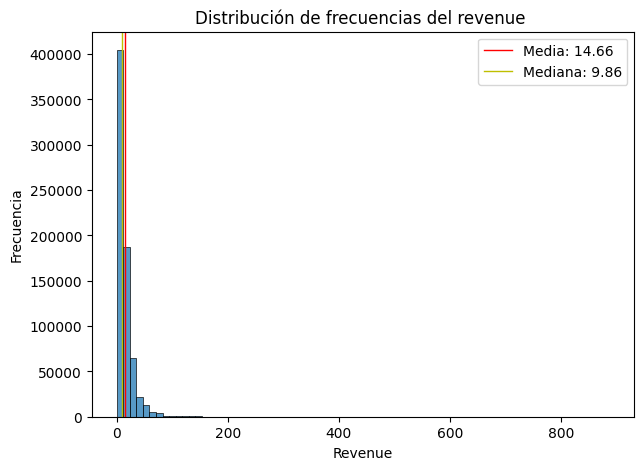

In [ ]:
plt.figure(figsize=(7, 5))
ax=sns.histplot(data=rev_positivo, x='revenue', bins=75)
plt.title('Distribución de frecuencias del revenue ')
media_revenue = rev_positivo['revenue'].mean()
mediana_revenue = rev_positivo['revenue'].median()

ax.axvline(media_revenue, color='r',  linewidth=1, label=f'Media: {media_revenue:.2f}')
ax.axvline(mediana_revenue, color='y', linewidth=1, label=f'Mediana: {mediana_revenue:.2f}')

plt.legend()
plt.xlabel('Revenue')
plt.ylabel('Frecuencia')
plt.show();

Puede verse una elevada concentración en valores cercanos a la media, pero también un número considerable de observaciones con valores bastante más altos de la media, nótese que la mediana es muy inferior a la media, ya que esta última se encuentra muy influenciada por valores extremos, recordemos que si la mediana es de \$9.86, valores superiores, por caso, a \$50, que como se observa en el gráfico son minoritarios pero no completamente irrelevantes, generan este fenómeno.

##**Correlación del revenue con las restantes variables**

In [ ]:
farmacia_excl_object= farmacia_final.select_dtypes(exclude=['object']) #Excluimos las variables no-numéricas de momento.


correlaciones=farmacia_excl_object.corr()
correlaciones_revenue = correlaciones['revenue']
correlaciones_revenue = correlaciones_revenue.drop('revenue', errors='ignore')
correlaciones_revenue_ordenado = correlaciones_revenue.sort_values(ascending=False)
correlaciones_revenue_ordenado = correlaciones_revenue_ordenado.to_frame(name='Correlación del revenue con las restantes variables')

print(correlaciones_revenue_ordenado)




                 Correlación del revenue con las restantes variables
order                                                     0.624785  
rrp                                                       0.224601  
competitorPrice                                           0.217004  
price                                                     0.216488  
adFlag                                                    0.072515  
unit_ST                                                   0.042587  
campaignIndex_D                                           0.031407  
pid                                                       0.019133  
salesIndex                                                0.006919  
unit_L                                                    0.006116  
campaignIndex_A                                           0.006102  
unit_KG                                                   0.000709  
unit_CM                                                  -0.000002  
unit_M                            

Como vemos, las mayores correlaciones se dan con order, lo cual es lógico, ya que para que haya revenue tiene que haber una venta, denotada por order=1, y una correlación positiva con los precios. De interés es la correlación negativa con acciones de los clientes que no representan ventas, como basket y click.

Más adelante después de crear una escala uniforme para todas las variabels vamos a revisitar todas las correlaciones para excluir variables altamente correlacionadas entre sí que puedan provocar problemas en la implementación de algoritmos, pero de este análisis preliminar podemos observar que los precios efectivos ('price'), los precios de la competencia ('competitorprice') y los precios de referencia ('rrp') están altamente correlacionados entre sí.

##**Distribución de precios.**

Como vemos, tenemos un precio promedio de \$13.85, una mediana de \$9.85 dolares, y un maximo de \$378.

Una propuesta de este trabajo es comenzar por *no excluir* outliers de nuestro análisis para la variable precio,  por caso, no tendría sentido exluir las variables de precio alto, siendo una farmacia, y atendiendo al contexto comercial descrito arriba, nos interesa saber si una parte sustancial de nuestro revenue proviene de un subconjunto reducido de productos con precios 'altos', que, observando el histograma, están lejos de representar un porcentaje ínfimo del revenue.

Cuando lleguemos al módulo de Machine Learning, vamos a constatar que esta es una decisión acertada, ya que la presencia de outliers no impide obtener predicciones adecuadas.

In [ ]:
print("Distribución del vector de precios")
print(round(farmacia_final.price.describe(),2))

Distribución del vector de precios
count    2756003.00
mean          13.85
std           13.62
min            0.02
25%            6.00
50%            9.85
75%           16.45
max          378.84
Name: price, dtype: float64


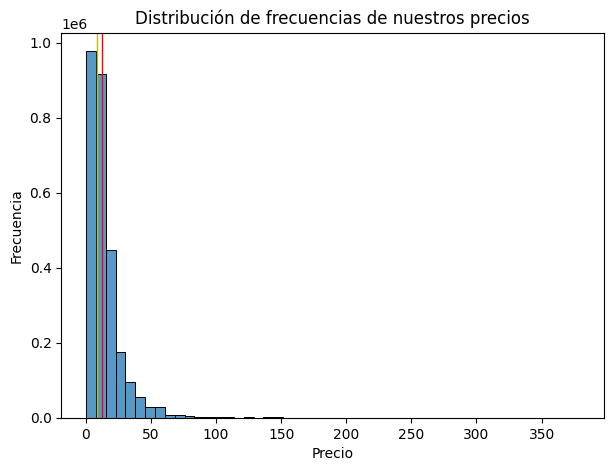

In [ ]:
plt.figure(figsize=(7, 5))
ax=sns.histplot(data=farmacia_final, x='price', bins=50)
plt.title('Distribución de frecuencias de nuestros precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

media_precio = rev_positivo['price'].mean()
mediana_precio = rev_positivo['price'].median()

ax.axvline(media_precio, color='r',  linewidth=1, label=f'Media: {media_precio:.2f}')
ax.axvline(mediana_precio, color='y', linewidth=1, label=f'Mediana: {mediana_precio:.2f}');

##**Curva de demanda**

Una curva de demanda relaciona las cantidades vendidas con los precios, en general esperamos que la relación sea negativa, a nivel agregado, para graficar la curva de demanda de un producto, necesitamos el precio en el eje x y la cantidad en el eje y, nuestro dataset no tiene las cantidades vendidas, pero podemos construirla dividiendo revenue por precio.

Como puede verse en el grafico, las cantidades vendidas son decrecientes en el precio, en el agregado.

In [ ]:
#Construimos la variable cantidad, dividiendo revenue por precio

farmacia_final['cantidad']=farmacia_final['revenue']/farmacia_final['price']

In [ ]:
farmacia_final['cantidad']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
2755998    4.0
2755999    0.0
2756000    0.0
2756001    0.0
2756002    0.0
Name: cantidad, Length: 2756003, dtype: float64

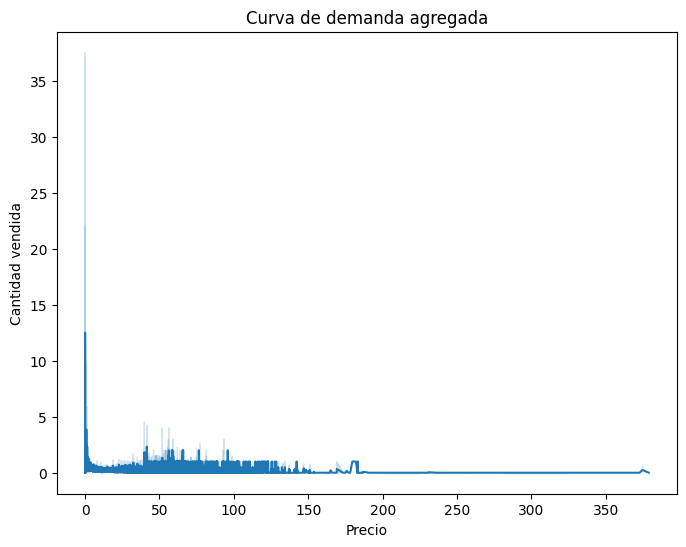

In [ ]:
#Graficamos la curva de demanda agregada

plt.figure(figsize=(8, 6))
sns.lineplot(data=farmacia_final, x='price', y='cantidad')
plt.title('Curva de demanda agregada')
plt.xlabel('Precio')
plt.ylabel('Cantidad vendida');

##**Análisis de las restantes variables**

En esta sección, vamos a analizar y graficar nuestras restantes variables, en su relación con el revenue, y en los casos que sea relevante, con los precios, habida cuenta de que el revenue es nuestra variable dependiente y los precios constituyen la variable que es ajustada diariamente

**Análisis del precio de referencia (rrp)**

El precio de referencia no es el precio efectivo, sino que este último fluctúa a diario alrededor del precio de referencia, generalmente, pero no siempre, por debajo, como se ilustra más adelante.

In [ ]:
Precios = farmacia['price'].describe()
Precios_de_referencia = farmacia['rrp'].describe()

# Print the descriptions
print("Distribución de los precios efectivos ")
print(round((Precios),2))

print("\nDistribución de los precios de referencia':")
print(round(Precios_de_referencia),2)

Distribución de los precios efectivos 
count    2756003.00
mean          13.85
std           13.62
min            0.02
25%            6.00
50%            9.85
75%           16.45
max          378.84
Name: price, dtype: float64

Distribución de los precios de referencia':
count    2756003.0
mean          18.0
std           19.0
min            0.0
25%            8.0
50%           13.0
75%           22.0
max          405.0
Name: rrp, dtype: float64 2


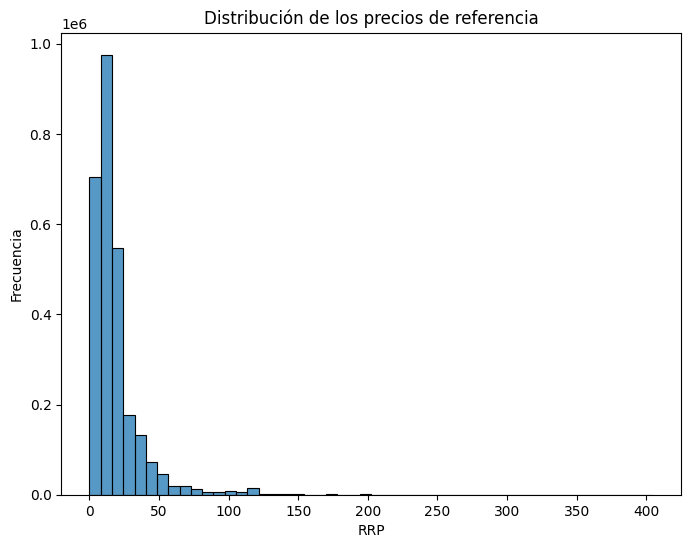

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=farmacia_final, x='rrp', bins=50)
plt.title('Distribución de los precios de referencia')
plt.xlabel('RRP')
plt.ylabel('Frecuencia');

Un Scatterplot de precios efectivos y de referencia nos muestra que los precios efectivos varían significativamente, fundamentalmente por debajo de los precios de referencia.

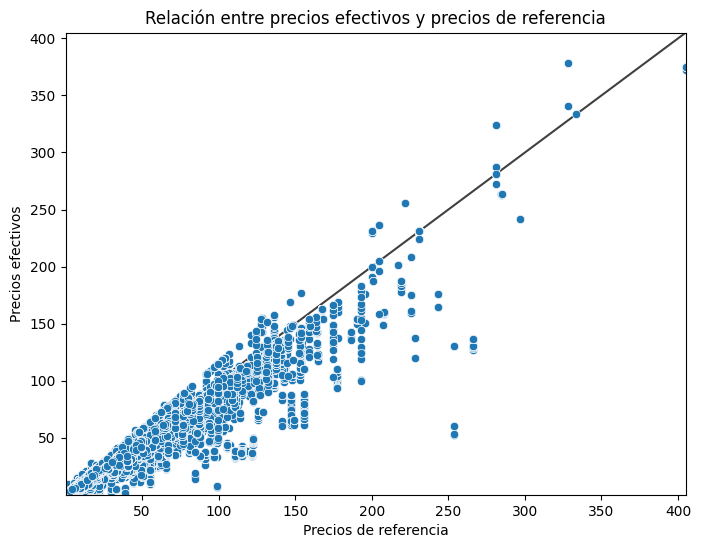

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=farmacia_final, x='rrp', y='price')
plt.title('Relación entre precios efectivos y precios de referencia')
plt.xlabel('Precios de referencia')
plt.ylabel('Precios efectivos')

#generamos una línea de 45 grados para graficar
rango = [
    np.min([np.min(farmacia_final['rrp']), np.min(farmacia_final['price'])]),
    np.max([np.max(farmacia_final['rrp']), np.max(farmacia_final['price'])]),
]


plt.plot(rango, rango, 'k-', alpha=0.75, zorder=0)
plt.xlim(rango)
plt.ylim(rango)

plt.show();

**Precios de la competencia (competitorPrice)**

Veamos la relación entre nuestros precios y los de la competencia.

Y como puede verse, existe una correlación positiva entre nuestros rangos de precio y los de la competencia para la casi totalidad de la muestra con algunos outliers en el rango donde tenemos un precio unitario superior a los $300, donde al parecer la competencia no llega a esos niveles. En función de este análisis, vemos que no somos una farmacia particularmente cara o premium ni una farmacia económica.

In [ ]:
print("Distribución de los precios de la competencia")
print(round(farmacia_final.competitorPrice.describe(),2))

Distribución de los precios de la competencia
count    2756003.00
mean          12.64
std           12.55
min            0.00
25%            5.49
50%            8.99
75%           14.84
max          264.59
Name: competitorPrice, dtype: float64


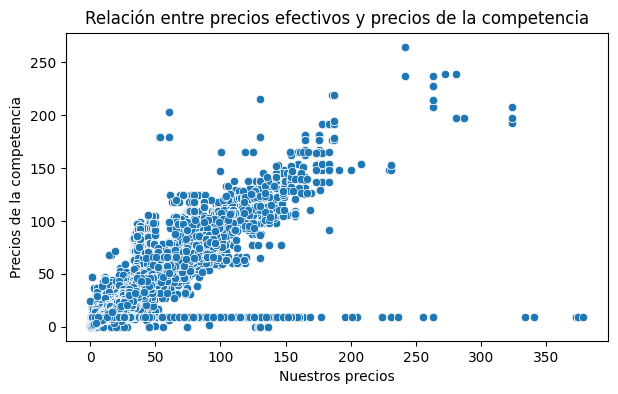

In [ ]:
plt.figure(figsize=(7, 4))
sns.scatterplot(data=farmacia_final, x='price', y='competitorPrice')
plt.title('Relación entre precios efectivos y precios de la competencia')
plt.xlabel('Nuestros precios')
plt.ylabel('Precios de la competencia');

###**Análisis temporal**

Como se ha explicado, nuestras observaciones corresponen a 91 días o 13 semanas de actividad en el sitio web de la farmacia, la relación entre revenue y días muestra una cierta estacionalidad semanal, no es constante a lo largo de los días, ni creciente o decreciente, y no se observan días que se desvíen demasiado de la tendencia establecida por la estacionalionad.

Recordemos que una de nuestras hipótesis auxiliares era que hay estacionalidad en las ventas, lo cual se comprueba en estos gráficos, no se puede ignorar la variable tiempo a la hora de explicar el revenue.

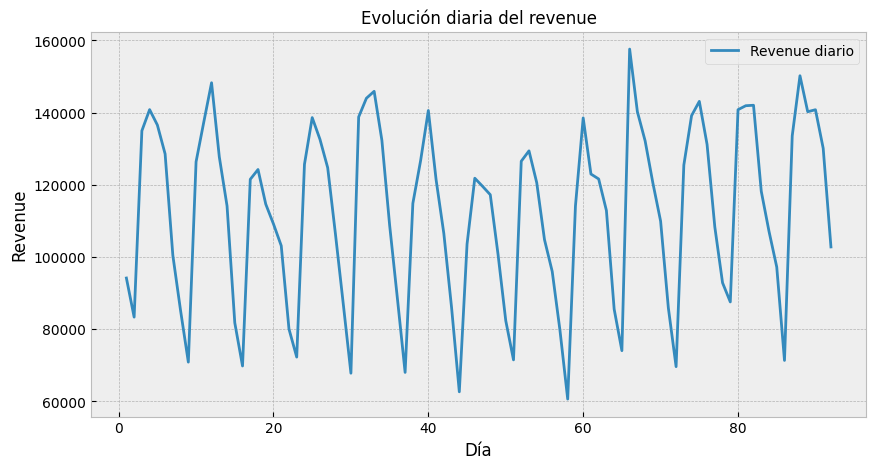

In [ ]:
revenue_diario = farmacia_final.groupby('day')['revenue'].sum() # Construimos una variable que sume el revenue diario.
mpl.style.use('bmh')
fig, ax = plt.subplots(figsize=(10 , 5))
ax.plot(revenue_diario, label ='Revenue diario') #pasamos la suma del revenue diario que construimos como variable a graficar
ax.set_title('Evolución diaria del revenue', fontsize='12')
ax.set_xlabel('Día', fontsize = '12')
ax.set_ylabel('Revenue', fontsize='12')
ax.legend(fontsize='10')
fig.show();

Continuando con la estacionalidad, si bien no tenemos las fechas o días de la semana, tenemos 91 días, es decir, 13 semanas, supongamos que el día 1 es un lunes, y a partir de allí vamos a construir una variable que le asigne el día de la semana a cada día.

In [ ]:
def dia_semana(day):
    dia_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
    return dia_semana[(day - 1) % 7]

farmacia_final['dia_semana'] = farmacia['day'].apply(dia_semana)

dias=['day','dia_semana']

dataset_dias = farmacia_final[dias]

dataset_dias

,day,dia_semana
0,1,Lunes
1,2,Martes
2,2,Martes
3,4,Jueves
4,5,Viernes
...,...,...
2755998,91,Domingo
2755999,91,Domingo
2756000,91,Domingo
2756001,91,Domingo


Ahora vamos a graficar la estacionalidad de las ventas por día de la semana. Los días de mayor revenue son los jueves y miercoles (tal como los hemos definido) y los días de menores ventas son los martes.  

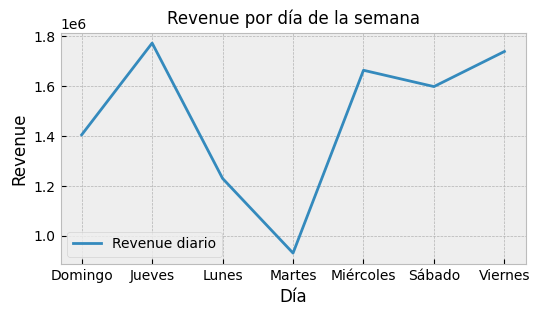

In [ ]:
revenue_diario = farmacia_final.groupby('dia_semana')['revenue'].sum() # Construimos una variable que sume el revenue diario.
mpl.style.use('bmh')
fig, ax = plt.subplots(figsize=(6 , 3))
ax.plot(revenue_diario, label ='Revenue diario') #pasamos la suma del revenue diario que construimos como variable a graficar
ax.set_title('Revenue por día de la semana', fontsize='12')
ax.set_xlabel('Día', fontsize = '12')
ax.set_ylabel('Revenue', fontsize='12')
ax.legend(fontsize='10')
fig.show();

Y también podemos graficar el comportamiento de los usuarios por día de la semana.

Vemos que los clicks alcanzan su mínimo los martes, al igual que el revenue, como vimos arriba, y las ventas, recordemos que ventas están representadas por order==1

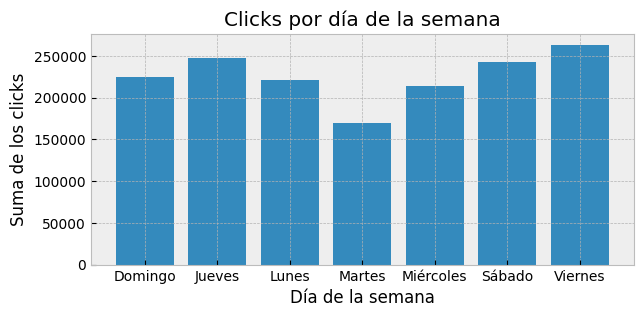

In [ ]:
agregacion_clicks = farmacia_final.groupby('dia_semana')['click'].sum().reset_index() # creamos una variable que agrega los clicks por día de la semana para graficar

plt.figure(figsize=(7, 3))

plt.bar(agregacion_clicks['dia_semana'], agregacion_clicks['click'])
plt.xlabel('Día de la semana')
plt.ylabel('Suma de los clicks')
plt.title('Clicks por día de la semana')
plt.show()

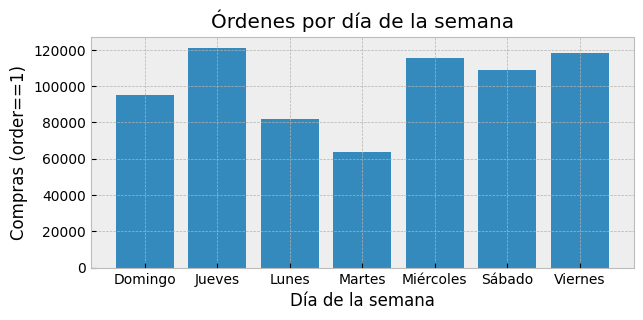

In [ ]:
agregacion_order = farmacia_final.groupby('dia_semana')['order'].sum().reset_index() # creamos una variable que agrega los clicks por día de la semana para graficar

plt.figure(figsize=(7, 3))

plt.bar(agregacion_order['dia_semana'], agregacion_order['order'])
plt.xlabel('Día de la semana')
plt.ylabel('Compras (order==1)')
plt.title('Órdenes por día de la semana')
plt.show()

###**Análisis de productos, grupos y fabricantes**

En esta sección vamos a analizar cual es la distribución precios, ventas y revenue por producto (variable pid), grupo de productos (variable group) y por fabricante (manufacturer)

In [ ]:
productos = farmacia['pid'].nunique()
print(f'Tenemos {productos} productos en nuestro dataset')

Tenemos 21928 productos en nuestro dataset


Veamos la concentración de revenue a nivel de producto.

Tenemos una elevadísima concentración, el 10% de los productos, de un total de casi 22 mil generan el 71% del revenue. El 1% general el 18%, claramente hay productos que son 'outliers' cuando se trata de revenue, pero no vamos a excluirlos, nos interesa su comportamiento, y, en función de nuestro objetivo comercial, es indispensable incluirlos en los modelos para generar predicciones de revenue adecuadas.

Para obtener una representación gráfica de esta concentración, vamos a usar las variables group y manufacturer

In [ ]:
farmacia_ordenada = farmacia_final.sort_values(by='revenue', ascending=False)

revenue_total = farmacia_ordenada['revenue'].sum() #Ordenamos por revenue

# Identificamos el top 1%, 10% y 50% de los productos:

percentil_1 = int(0.01 * len(farmacia_ordenada))
productos_percentil_1 = farmacia_ordenada.head(percentil_1)

percentil_10 = int(0.1 * len(farmacia_ordenada))
productos_percentil_10 = farmacia_ordenada.head(percentil_10)

percentil_50 = int(0.5 * len(farmacia_ordenada))

# Calculamos el revenue generado por el top 1%, 10% y 50% de los productos
revenue_percentil_1 = productos_percentil_1['revenue'].sum()
revenue_percentil_10 = productos_percentil_10['revenue'].sum()

print(f"Revenue total: ${revenue_total:.1f}")
print(f"Revenue generado por el 1% de los productos con más revenue: {(revenue_percentil_1/revenue_total)*100:.2f} % ")
print(f"Revenue generado por el 10% de los productos con más revenue: {(revenue_percentil_10/revenue_total)*100:.2f} % ")


Revenue total: $10337709.6
Revenue generado por el 1% de los productos con más revenue: 18.76 % 
Revenue generado por el 10% de los productos con más revenue: 71.36 % 


In [ ]:
grupos = farmacia_final.groupby('group')['pid'].count()

productos_por_grupo = grupos.mean()

print("Tenemos", len(grupos), "grupos")

print(f"Promedio de productos por grupo: {productos_por_grupo:.0f}")

Tenemos 533 grupos
Promedio de productos por grupo: 5171


Text(0, 0.5, 'Revenue')

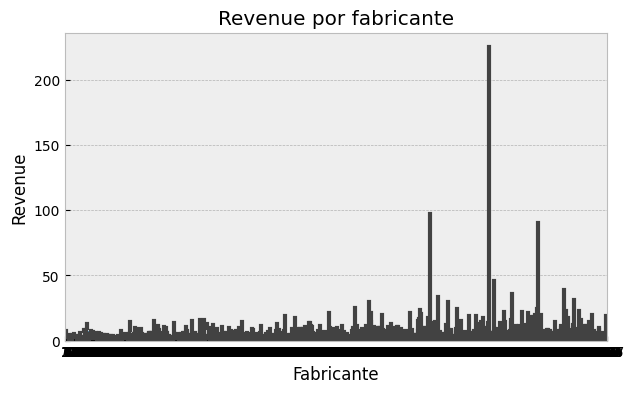

In [ ]:
plt.figure(figsize=(7, 4))
sns.barplot(data=farmacia_final, x='manufacturer', y='revenue')
plt.title('Revenue por fabricante')
plt.xlabel('Fabricante')
plt.ylabel('Revenue')

Text(0, 0.5, 'Revenue')

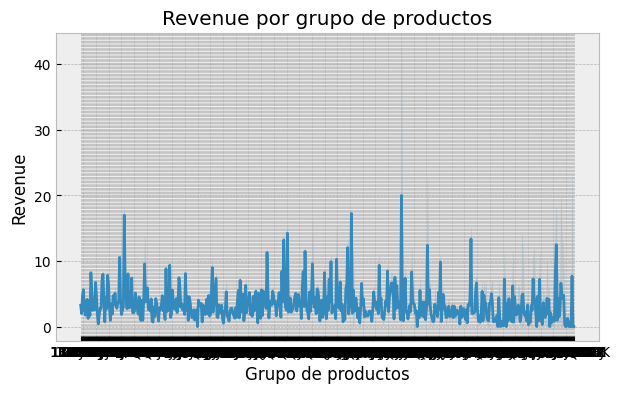

In [ ]:
plt.figure(figsize=(7, 4))
sns.lineplot(data=farmacia_final, x='group', y='revenue')
plt.title('Revenue por grupo de productos')
plt.xlabel('Grupo de productos')
plt.ylabel('Revenue')

###**Acciones de los clientes**

En estas secciones pasamos al análisis de las acciones de los clientes, recordemos que,

> click representa si un cliente hizo click en un producto en el sitio web
> basket representa si un cliente colocó un producto en un carrito de compras
> order representa una compra.

Las 3 variables toman los valores {0,1}

Un análisis gráfico de las acciones de los clientes nos lleva a la conclusión de que cerca del 26% de los clicks derivan eventualmente en una compra, ya que tenemos 705000 orders vs 2.75 millones de clicks.

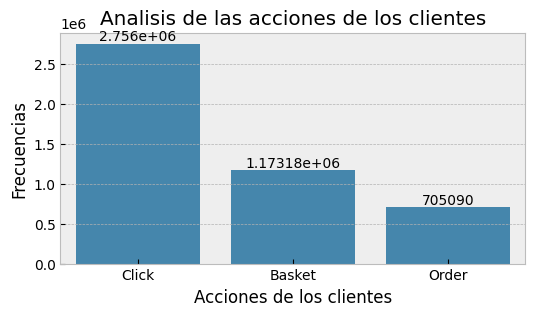

In [ ]:
click_basket = (farmacia_final['click'] + farmacia_final['basket'] + farmacia_final['order']).sum() # Creamos una variable para ver como pasamos de click a basket y order
basket_order = (farmacia_final['basket'] + farmacia_final['order']).sum() # Suma de las observaciones con bastket y order
click_order = farmacia_final['order'].sum()

datos = {'Step': ['Click', 'Basket', 'Order'], 'Count': [click_basket, basket_order, click_order]}
plt.figure(figsize=(6, 3))
grafico=sns.barplot(data=datos, x='Step', y='Count')
plt.title('Analisis de las acciones de los clientes')
plt.xlabel('Acciones de los clientes')
plt.ylabel('Frecuencias')
grafico.bar_label(grafico.containers[0], fontsize=10);

Veamos los precios y revenue asociados a las acciones de clientes, incluyendo order (compras) condicional en que sea haya puesto un producto en una canasta

In [ ]:
#Calculamos las medianas de los precios y el desvío para combinaciones de order y basket:

mediana_precio_canasta_0 = farmacia_final[farmacia_final['basket'] == 0]['price'].median()
desvio_precio_canasta_0 = farmacia_final[farmacia_final['basket'] == 0]['price'].std()

mediana_precio_canasta_1 = farmacia_final[farmacia_final['basket'] == 1]['price'].median()
desvio_precio_canasta_1 = farmacia_final[farmacia_final['basket'] == 1]['price'].std()

mediana_precio_order_0 = farmacia_final[farmacia_final['order'] == 0]['price'].median()
desvio_precio_order_0 = farmacia_final[farmacia_final['order'] == 0]['price'].std()

mediana_precio_order_1 = farmacia_final[farmacia_final['order'] == 1]['price'].median()
desvio_precio_order_1 = farmacia_final[farmacia_final['order'] == 1]['price'].std()

#El código que sigue busca analiza los precios cuando un cliente coloca un producto en una canasta, pero a veces termina comprando (order==1) y a veces no
mediana_precio_canasta1_order_0 = farmacia_final[(farmacia_final['basket'] == 1) & (farmacia_final['order'] == 0)]['price'].median()
desvio_precio_canasta1_order_0 = farmacia_final[(farmacia_final['basket'] == 1) & (farmacia_final['order'] == 0)]['price'].std()

mediana_precio_canasta1_order_1 = farmacia_final[(farmacia_final['basket'] == 1) & (farmacia_final['order'] == 1)]['price'].median()
desvio_precio_canasta1_order_1 = farmacia_final[(farmacia_final['basket'] == 1) & (farmacia_final['order'] == 1)]['price'].std()

# En esta seccion calculamos el revenue para distintas combinaciones
sum_revenue_canasta_0 = farmacia_final[farmacia_final['basket'] == 0]['revenue'].sum()
desvio_revenue_canasta_0 = farmacia_final[farmacia_final['basket'] == 0]['revenue'].std()

sum_revenue_canasta_1 = farmacia_final[farmacia['basket'] == 1]['revenue'].sum()
desvio_revenue_canasta_1 = farmacia_final[farmacia['basket'] == 1]['revenue'].std()

sum_revenue_order_0 = farmacia_final[farmacia_final['order'] == 0]['revenue'].sum()
desvio_revenue_order_0 = farmacia_final[farmacia_final['order'] == 0]['revenue'].std()

# El siguiente código busca el revenue para distintas combinaciones de order y basket:

revenue_order_1 = farmacia_final[farmacia_final['order'] == 1]['revenue'].sum()
desvio_revenue_order_1 = farmacia_final[farmacia['order'] == 1]['revenue'].std()

revenue_basket1_order_0 = farmacia_final[(farmacia_final['basket'] == 1) & (farmacia_final['order'] == 0)]['revenue'].sum()
desvio_revenue_basket1_order_0 = farmacia_final[(farmacia_final['basket'] == 1) & (farmacia_final['order'] == 0)]['revenue'].std()

revenue_basket1_order_1 = farmacia[(farmacia['basket'] == 1) & (farmacia_final['order'] == 1)]['revenue'].sum()
desvio_revenue_basket1_order_1 = farmacia_final[(farmacia_final['basket'] == 1) & (farmacia_final['order'] == 1)]['revenue'].std()

#Armamos una tabla para facilitar la visualizacion

data = {
    'Medianas de los precios': [mediana_precio_canasta_0, desvio_precio_canasta_0, mediana_precio_order_0,
                     desvio_precio_order_1, mediana_precio_canasta1_order_0, mediana_precio_canasta1_order_1],

    'Desvío de los precios': [desvio_precio_canasta_0, desvio_precio_canasta_1, desvio_precio_order_0,
                      desvio_precio_order_1, desvio_precio_canasta1_order_0, desvio_precio_canasta1_order_1],

    'Revenue': [sum_revenue_canasta_0, sum_revenue_canasta_1, sum_revenue_order_0,
                    revenue_order_1, desvio_revenue_basket1_order_0, revenue_basket1_order_1],

    'Desvío del revenue': [desvio_revenue_canasta_0, desvio_revenue_canasta_1, desvio_revenue_order_0,
                        desvio_revenue_order_1, desvio_revenue_basket1_order_0, desvio_revenue_basket1_order_1]
}

matriz_resultados = pd.DataFrame(data, index=['Basket==0', 'Basket==1', 'Order==0', 'Order==1', 'Basket==1, Order==0', 'Basket==1, Order==1'])

print(f'Mediana de los precios de productos colocados en una canasta: {mediana_precio_canasta_1:.2f}')
print(f'Desvío estandar de los precios de productos colocados en una canasta: {desvio_precio_canasta_1:.2f}')
print(f'Mediana de los precios de productos no comprados (order==0): {mediana_precio_order_0:.2f}')
print(f'Desvío estandar de los precios de productos no comprados (order==0): {desvio_precio_order_0:.2f}')
print(f'Mediana de los precios de productos comprados (order==1): {mediana_precio_order_1:.2f}')
print(f'Desvío estándar de los precios de productos comprados (order==1): {desvio_precio_order_1:.2f}')
print(f'Mediana de los precios de productos colocados en una canasta pero no comprados luegdo: {mediana_precio_canasta1_order_0:.2f}')
print(f'Desvío estándar de los precios de productos colocados en una canasta pero no comprados luegdo: {desvio_precio_canasta1_order_0:.2f}')
print(f'Mediana de los precios de productos que fueron tanto puestos en una canasta como comprados: {mediana_precio_canasta1_order_1:.2f}')
print(f'Desvío estándar de los precios de productos que fueron tanto puestos en una canasta como comprados: {desvio_precio_canasta1_order_1:.2f}')
print(f'Revenue generado por productos comprados y su desvío: {revenue_order_1:.2f} y {desvio_revenue_order_1:.2f} ')
print(f'Revenue generado por productos comprados previamente colocados en una canasta y su desvío: {revenue_order_1:.2f} y {desvio_revenue_order_1:.2f} ')


Mediana de los precios de productos colocados en una canasta: 9.85
Desvío estandar de los precios de productos colocados en una canasta: 11.11
Mediana de los precios de productos no comprados (order==0): 10.39
Desvío estandar de los precios de productos no comprados (order==0): 14.18
Mediana de los precios de productos comprados (order==1): 8.75
Desvío estándar de los precios de productos comprados (order==1): 11.66
Mediana de los precios de productos colocados en una canasta pero no comprados luegdo: 9.85
Desvío estándar de los precios de productos colocados en una canasta pero no comprados luegdo: 11.11
Mediana de los precios de productos que fueron tanto puestos en una canasta como comprados: nan
Desvío estándar de los precios de productos que fueron tanto puestos en una canasta como comprados: nan
Revenue generado por productos comprados y su desvío: 10337709.63 y 15.81 
Revenue generado por productos comprados previamente colocados en una canasta y su desvío: 10337709.63 y 15.81 


De las medidas calculadas previamente se puede ver que los precios de productos no comprados son más altos que los comprados y aquellos que son colocados en una canasta, que la dispersión de precios es muy alta, como se había constatado anteriormente. Los clientes parecen priorizar en sus actividades productos de precios relativamente bajos.

###**Medicamentos genéricos**

En esta sección analizamos medicamentos genéricos, vamos a estimar, por un lado, el precio mediano de genéricos y no genéricos, y luego veremos como nuestro revenue se ve impactado por esta variable.

En primer lugar, constatamos que los no génericos tienen un precio mucho más elevado,  10.95dólaresporproducto,versusapenas 4.68 dólares para los genéricos, siendo el precio mediano del conjunto de la muestra de $9.85.

Por otro lado, en el boxplot graficado vemos que los medicamentos no genéricos explican la gran mayoría de nuestro revenue, con un conjunto no despreciable de outliers por encima de los $600 de revenue generado.



In [ ]:
precio_mediana=farmacia_final.price.median()

precio_genéricos=farmacia_final.loc[farmacia_final['genericProduct'] == 1, 'price'].median()
precio_no_genéricos=farmacia_final.loc[farmacia_final['genericProduct'] == 0, 'price'].median()

print(f'Mediana de todos los precios: {precio_mediana}')
print(f'Mediana de los precios de genéricos: {precio_genéricos}')
print(f'Mediana de los precios de no genéricos: {precio_no_genéricos}')

Mediana de todos los precios: 9.85
Mediana de los precios de genéricos: 4.68
Mediana de los precios de no genéricos: 10.95


Text(0, 0.5, 'Revenue')

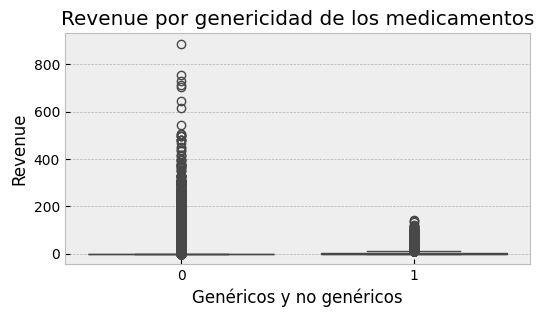

In [ ]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=farmacia_final, x='genericProduct', y='revenue')
plt.title('Revenue por genericidad de los medicamentos')
plt.xlabel('Genéricos y no genéricos')
plt.ylabel('Revenue')

In [ ]:
#Proporción de genericos en las ventas

ventas_ordenadas = farmacia_final[farmacia_final['order'] == 1]
ventas_genericas = ventas_ordenadas['genericProduct'].mean()
print(f"Propoción de genéricos en las ventas: {ventas_genericas:.2f}")

Propoción de genéricos en las ventas: 0.15


Como vemos, el 15% de las ventas son medicamentos genéricos.

###**Publicidad**


Tenemos productos que han sido publicitados, adFlag==1 nos indica que un producto es objeto de una campaña de publicidad.

A su vez, tenemos 3 tipos de campañas de publicidad (variable campaingIndex), que toma los valores {A,B,C}

Veamos primero que proporción de nuestras observaciones son objeto de campaña publicitaria, cual es el precio mediano (la mediana es una mejor medida de tendencia central cuando tenemos distribuciones con alta dispersión, en mi opinión) de los productos publicitados versus los que no, y como se relacionan con el revenue.


In [ ]:
#Calculo de porcentajes de observaciones con y sin campaña publicitaria.

adflag_0 = farmacia_final['adFlag'].value_counts().get(0, 0)
adflag_1 = farmacia_final['adFlag'].value_counts().get(1, 0)
total_observaciones = len(farmacia)

porcentaje_0s = (adflag_0 / total_observaciones) * 100
porcentaje_1s = (adflag_1 / total_observaciones) * 100

print(f"Observaciones sin campaña publicitaria: {porcentaje_0s:.2f}%")
print(f"Observaciones sin campaña publicitaria: {porcentaje_1s:.2f}%")

Observaciones sin campaña publicitaria: 68.22%
Observaciones sin campaña publicitaria: 31.78%


In [ ]:
# Calculo de precio mediano en función del atributo adFlag.

mediana_precios = farmacia_final.groupby('adFlag')['price'].median()
mediana_general=farmacia_final['price'].median()

print('Mediana de los precios en función del atributo adFlag')
print(mediana_precios)
print('\n')
print(f'Mediana general de los precios: {mediana_general}')

Mediana de los precios en función del atributo adFlag
adFlag
0     9.85
1    10.95
Name: price, dtype: float64


Mediana general de los precios: 9.85


Vemos que los productos publicitados son algo más caros que los productos no publicitados, que a su vez están cerca de la mediana general de la muestra

In [ ]:
#Análisis de revenue en función del atributo adFlag

revenue_adflag_1 = farmacia[farmacia['adFlag'] == 1]['revenue'].sum()
revenue_adflag_0 = farmacia[farmacia['adFlag'] == 0]['revenue'].sum()

porcentaje_revenue_adflag_1 = (revenue_adflag_1 / farmacia['revenue'].sum()) * 100
porcentaje_revenue_adflag_0 = (revenue_adflag_0 / farmacia['revenue'].sum()) * 100

print(f"Porcentaje de revenue generado por productos publicitados: {porcentaje_revenue_adflag_1:.2f}%")
print(f"Porcentaje de revenue generado por productos no publicitados: {porcentaje_revenue_adflag_0:.2f}%")

Porcentaje de revenue generado por productos publicitados: 41.00%
Porcentaje de revenue generado por productos no publicitados: 59.00%


El 41% del revenue es generado por productos publicitados, en comparación con el 31% de observaciones que represeta productos publicitados. Esto en parte se debe a que el precio promedio de los productos publicitados es más alto, y probablemente porque las campañas publicitarias tengan cierta efectividad a la hora de generar ventas.

Es interesante observare en el boxplot que hay más oultiers de revenue alto cuando no hay campaña publicitaria, más allá que en el agregado el revenue relacionado con productos publicitados sea proporcionalmente más alto respecto al universo de productos.

Text(0, 0.5, 'Revenue')

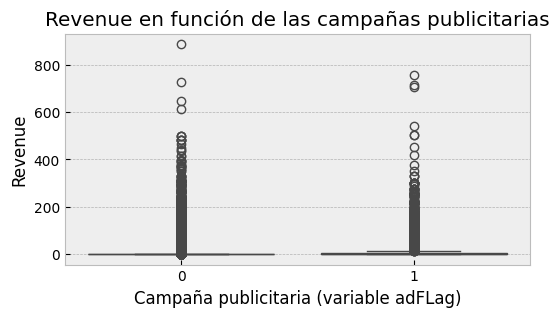

In [ ]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=farmacia, x='adFlag', y='revenue')
plt.title('Revenue en función de las campañas publicitarias')
plt.xlabel('Campaña publicitaria (variable adFLag)')
plt.ylabel('Revenue')

#**Conclusiones del EDA**

En función de nuestro objetivo general de predecir el revenue, podemos ver en el EDA que,

> Tenemos un dataset que tiene pocos datos faltantes, y con algunas transformaciones podemos aprovechar la totalidad de las observaciones.

> El revenue exhibe una fuerte concentración a nivel de productos y fabricante.

> El revenue no sigue una distribución aproximadamente normal, sino una elevadísima concentración alrededor de la mediana con una cola derecha 'larga' que da cuenta de la presencia de outliers.

> Dicho esto, no vamos a excluir los outliers de nuestro análisis, si pensamos en el contexto comercial, nos interesa predecir la totalidad del revenue, y si hay productos de precio elevado que representan una fracción material de las ventas, estamos interesados en conocer como influyen en el revenue. Sólo si constatamos que este factor está afectando significativamente la predicción habremos de excluir outliers o segementar los modelos (algo que, veremos, no será necesario).

> Los precios también exhiben una alta concentración alrededor de la mediana, con una cola larga a la derecha, que representa una proporción importante de productos 'caros'.

> Nuestros precios están altamente correlacionados con los precios de referencia y los de la competencia. Además de ser una observación interesante en sí misma, esto nos habla de cierta redundancia de variables a la hora de aplicar modelos de ML.

> Con respecto a la variable tiempo, hay fluctuaciones al interior de las 13 semanas de observaciones, en lugar de tener fluctuaciones estacionales, semanales, o de un revenue constante a lo largo del tiempo. Los picos de ventas son miercoles y jueves (tal como los hemos definido, el dataset no indica día de la semana, simplemente tomamos el día 1 como "Lunes" para empezar a contar), con una fuerte caída los martes. Pensando en la aplicación de modelos de predicción de revenue, la dimensión temporal no puede ser ignorada.

> Los productos genéricos son bastante más económicos que los no genéricos, pero explican una proporción más elevada del revenue dado que son la inmensa mayoría de los productos.

> En cuanto a la publicidad, el 31% de nuestros productos son objetos de alguna campaña de publicidad, y generan el 41% del revenue, si bien el precio promedio de los productos publicitados es un ~10% más elevado que el resto, podría decirse que existe un cierto efecto de la publicidad en las ventas. Más adelante daremos un tratamiento específico a esta variable categórica para incluir en los modelos de Machine Learning.

#**Finalización de la limpieza de datos , cambio de escala y preparación del dataset para aplicación de modelos de ML**


##**Cambio de escala de variables numéricas continuas**

En esta sección vamos a usar el módulo StandarScaler de scikit-learn para modificar la escala de un conjunto de variables numéricas continuas, no categóricas.

En concreto, vamos a re-escalar los precios (price), precios de referencia (rrp), precios de la competencia y nuestra variable dependiente, revenue.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
variables_re_escaladas = ["revenue", "price", "rrp" , "competitorPrice"] # las 4 variables que vamos a re-escalar.

scaler = StandardScaler() #creamos un objeto que sea el Scaler de sklearn.

columnas_re_escaladas = scaler.fit_transform(farmacia_final[variables_re_escaladas]) #Aplicamos ("fiteamos") el scaler a nuestro set de variables de interés

dataset_re_escalado = pd.DataFrame(columnas_re_escaladas, columns=variables_re_escaladas) # Se genera un dataset con nuevas escalas para nuestras variables de interés

variables_no_re_escaladas = farmacia_final.drop(columns=variables_re_escaladas) # las restantes columnas del dataset

farmacia_re_escalada = pd.concat([dataset_re_escalado, variables_no_re_escaladas], axis=1) # Concatenamos las variables con cambio de escala con el resto.


In [ ]:
farmacia_re_escalada

,revenue,price,rrp,competitorPrice,lineID,day,pid,adFlag,availability,click,...,unit_M,unit_ML,unit_P,unit_ST,campaignIndex_A,campaignIndex_B,campaignIndex_C,campaignIndex_D,cantidad,dia_semana
0,-0.366336,0.223145,-0.003165,0.155889,1,1,6570,0,2,1,...,False,True,False,False,False,False,False,True,0.0,Lunes
1,-0.366336,0.223145,-0.003165,0.155889,20746,2,6570,0,2,0,...,False,True,False,False,False,False,False,True,0.0,Martes
2,-0.366336,0.223145,-0.003165,0.155889,35477,2,6570,0,2,1,...,False,True,False,False,False,False,False,True,0.0,Martes
3,-0.366336,0.223145,-0.003165,0.155889,61647,4,6570,0,2,1,...,False,True,False,False,False,False,False,True,0.0,Jueves
4,-0.366336,0.223145,-0.003165,0.155889,87130,5,6570,0,2,0,...,False,True,False,False,False,False,False,True,0.0,Viernes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,1.942442,-0.582841,-0.647802,-0.291124,2712203,91,20700,0,2,0,...,False,False,False,False,False,False,False,True,4.0,Domingo
2755999,-0.366336,-0.061666,-0.246980,-0.291124,2713825,91,12000,0,2,1,...,False,False,False,True,False,False,False,True,0.0,Domingo
2756000,-0.366336,-0.805992,-0.818740,-0.813834,2714766,91,10485,0,2,1,...,False,False,False,False,False,False,False,True,0.0,Domingo
2756001,-0.366336,-0.666523,-0.759260,-0.713435,2718999,91,15158,0,2,1,...,False,False,False,True,False,False,False,True,0.0,Domingo


#**División del Dataset en variables explicativas (X) y dependientes (y)**



Seleccionamos nuestra variable dependiente **revenue** y excluimos las variables categoricas que encodeamos para no generar duplicaciones.

Tambien eliminamos lineID como variable independiente, no tiene valor explicativo

In [ ]:
X = farmacia_re_escalada.drop([ 'lineID' , 'group', 'content', 'unit', 'category','campaignIndex', 'pharmForm' , 'dia_semana' ], axis=1)

y = farmacia_re_escalada['revenue']

#**Análisis de correlación entre variables**

En esta sección vamos a analizar la correlación entre variables para entender si existen redundancias que lleven a la exclusión de ciertas variables de los modelos de regresión.

In [ ]:
matriz_correlaciones=X.corr()

In [ ]:
matriz_correlaciones

,revenue,price,rrp,competitorPrice,day,pid,adFlag,availability,click,basket,...,unit_L,unit_M,unit_ML,unit_P,unit_ST,campaignIndex_A,campaignIndex_B,campaignIndex_C,campaignIndex_D,cantidad
revenue,1.000000,0.216488,0.224601,0.217004,-0.040944,0.019133,0.072515,-0.048652,-0.425515,-0.165700,...,0.006116,-0.002347,-0.019217,-0.012397,0.042587,0.006102,-0.033104,-0.022620,0.031407,0.526057
price,0.216488,1.000000,0.935825,0.903516,0.022835,0.109019,0.023665,0.051254,0.109766,-0.050823,...,0.017222,-0.009903,-0.048417,0.029603,0.125061,-0.026750,-0.084228,-0.076005,0.112807,-0.083667
rrp,0.224601,0.935825,1.000000,0.930234,0.019674,0.073575,0.061104,0.008324,0.081443,-0.035971,...,0.014102,-0.008675,-0.022759,0.020095,0.106752,-0.019933,-0.065750,-0.059531,0.087582,-0.068264
competitorPrice,0.217004,0.903516,0.930234,1.000000,0.023548,0.083797,0.014269,0.030778,0.100146,-0.047180,...,0.016752,-0.007803,-0.007379,0.014422,0.095440,-0.024428,-0.088026,-0.076989,0.114765,-0.075196
day,-0.040944,0.022835,0.019674,0.023548,1.000000,0.002313,-0.024418,0.019050,0.116116,-0.063016,...,0.001914,-0.001436,-0.014463,0.002366,0.018343,-0.065281,0.010817,-0.018916,0.038427,-0.043132
pid,0.019133,0.109019,0.073575,0.083797,0.002313,1.000000,-0.123018,0.006680,0.086887,-0.072414,...,-0.017387,-0.003991,-0.006759,0.020697,0.016871,-0.075847,-0.120344,-0.059332,0.162542,-0.030218
adFlag,0.072515,0.023665,0.061104,0.014269,-0.024418,-0.123018,1.000000,-0.173211,-0.179366,0.115209,...,0.001383,-0.009996,-0.063847,-0.044788,0.023157,0.095029,0.176199,-0.007940,-0.188195,0.052745
availability,-0.048652,0.051254,0.008324,0.030778,0.019050,0.006680,-0.173211,1.000000,0.119770,-0.054229,...,-0.001477,-0.000418,-0.010850,-0.000472,0.004720,-0.032812,-0.074494,-0.021923,0.085944,-0.054408
click,-0.425515,0.109766,0.081443,0.100146,0.116116,0.086887,-0.179366,0.119770,1.000000,-0.525385,...,0.002010,-0.001625,-0.024407,0.028697,0.017146,-0.038149,-0.129111,0.004735,0.119702,-0.409432
basket,-0.165700,-0.050823,-0.035971,-0.047180,-0.063016,-0.072414,0.115209,-0.054229,-0.525385,1.000000,...,-0.001407,-0.000751,0.056113,-0.012898,-0.039719,0.013040,0.171105,-0.009179,-0.135165,-0.159437


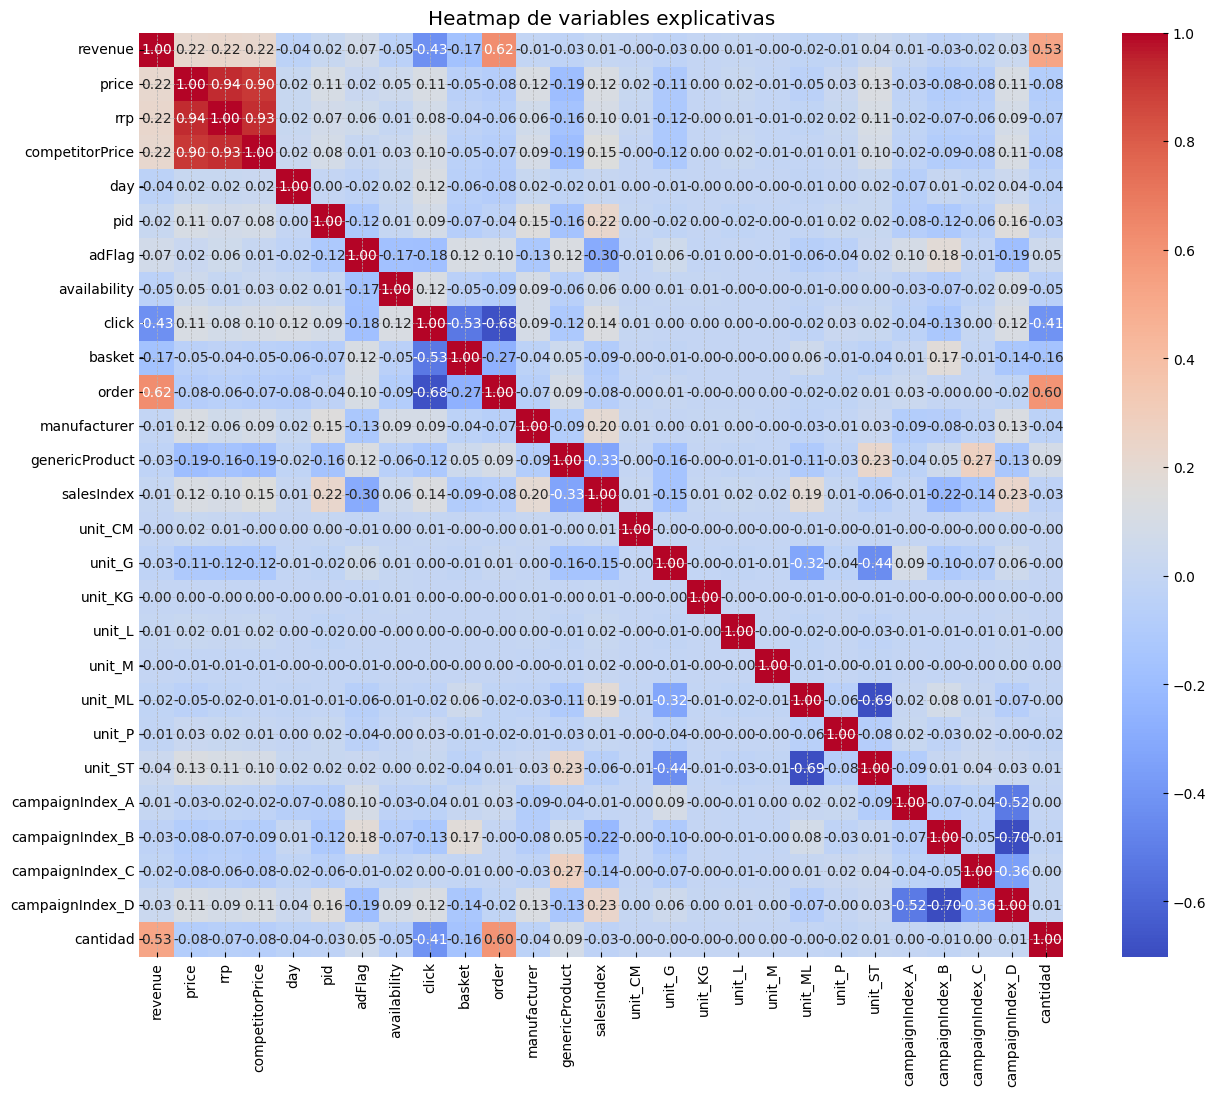

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(matriz_correlaciones, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Heatmap de variables explicativas')
plt.show()

En una inspección visual, observamos una elevada: correlación entre entre los precios, los precios de la competencia, precios de referencia, entre los distintos CampaignIndex.

Vamos a seleccionar las variables con un indice de correlación de más de 0.7 (valor absoluto) y tomarlo como umbral para considerar si una variable puede ser eliminada del vector X de variables explicativas.

In [ ]:
variables_correlacionadas = [] #generamos la lista donde vamos a guardar las variables

for i in range(len(matriz_correlaciones.columns)): #función donde vamos agregando las variable con correlacion mayor a +/- 0.7
    for j in range(i+1, len(matriz_correlaciones.columns)):
        correlation = matriz_correlaciones.iloc[i, j]
        if abs(correlation) > 0.7:
            pares = matriz_correlaciones.columns[i] + ' - ' + matriz_correlaciones.columns[j]
            variables_correlacionadas.append((pares, correlation))

for pair, correlation in variables_correlacionadas:
    print(f"Variables: {pair}, Coeficiente de correlación: {correlation:.2f}")


Variables: price - rrp, Coeficiente de correlación: 0.94
Variables: price - competitorPrice, Coeficiente de correlación: 0.90
Variables: rrp - competitorPrice, Coeficiente de correlación: 0.93
Variables: campaignIndex_B - campaignIndex_D, Coeficiente de correlación: -0.70


Como puede verse, los precios están correlacionados con los precios de referencia y los precios de la competencia.

Con respecto a los Campaingindex, recordemos que se trata de una variable dummy que generamos a partir del tipo de campaña, la variable que nos dice si un producto es objeto de una campaña publicitaria es adFlag, que toma valores 0 y 1. Si adFlag=0 (no hay campaña), generamos la dummy campaignIndex_D.

Si bien el análisis previo nos indica que tenemos alta correlación entre las campañas B y D, vamos a eliminar todas nuestras variables campaignIndex, la variable adFlag es suficiente para captar el efecto de la publicidad en la probabilidad de ventas.

Finalmente, vamos a eliminar las dummies de 'unit', que indica la unidad del producto, y originalmente es un string de mayúsculas y 'salesIndex'. Esto lo hacemos para simplificar el modelo y suponemos que las variables pid y manufacturer nos la información que necesitamos sobre como un producto determinado afecta las ventas.

In [ ]:
X = farmacia_re_escalada.drop([ 'lineID' , 'group', 'content', 'unit', 'category','campaignIndex', 'pharmForm'  ,

'rrp', 'competitorPrice', 'unit_CM', 'unit_G',  'unit_KG' , 'unit_L' , 'unit_M' , 'unit_P' , 'unit_ST', 'campaignIndex_A' , 'unit_ML',

 'campaignIndex_B' , 'campaignIndex_C' , 'campaignIndex_D' ,'revenue', 'salesIndex'], axis=1)

y = farmacia_re_escalada['revenue']

In [ ]:
#Constatamos que sólo nos quedamos con las variables que nos interesan

X.dtypes

price             float64
day                 int64
pid                 int64
adFlag              int64
availability        int64
click               int64
basket              int64
order               int64
manufacturer        int64
genericProduct      int64
cantidad          float64
dia_semana         object
dtype: object

#**Agrupamiento de productos y días de la semana**

##**Agrupamiento de productos**

Recordemos que tenemos 22 mil productos, identificados por valor numérico, pero no queremos que el valor numérico de un producto, que es puramente descriptivo, genere confusión en los cálculos de las regresiones.

Como una forma de agrupar los productos en un conjunto reducido de variables categóricas, vamos a generar dummies que nos indiquen si un producto es de precio 'bajo', 'medio', 'caro', el criterio es dividir el rango de precios en tercios y asignarlos a estas categorias

In [ ]:
#Dividimos el vector X de variables explicativas en tres cuantiles que se basan en los precios.

cuantiles = pd.qcut(X['price'], q=3, labels=['barato', 'medio', 'caro'])

dummies_cuantiles = pd.get_dummies(cuantiles)

# Lo concatenamos con X

nuevo_X = pd.concat([X, dummies_cuantiles], axis=1)



In [ ]:
nuevo_X

,price,day,pid,adFlag,availability,click,basket,order,manufacturer,genericProduct,cantidad,dia_semana,barato,medio,caro
0,0.223145,1,6570,0,2,1,0,0,255,0,0.0,Lunes,False,False,True
1,0.223145,2,6570,0,2,0,1,0,255,0,0.0,Martes,False,False,True
2,0.223145,2,6570,0,2,1,0,0,255,0,0.0,Martes,False,False,True
3,0.223145,4,6570,0,2,1,0,0,255,0,0.0,Jueves,False,False,True
4,0.223145,5,6570,0,2,0,1,0,255,0,0.0,Viernes,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,-0.582841,91,20700,0,2,0,0,1,753,0,4.0,Domingo,True,False,False
2755999,-0.061666,91,12000,0,2,1,0,0,811,0,0.0,Domingo,False,True,False
2756000,-0.805992,91,10485,0,2,1,0,0,61,0,0.0,Domingo,True,False,False
2756001,-0.666523,91,15158,0,2,1,0,0,811,0,0.0,Domingo,True,False,False


In [ ]:
#eliminamos la variable pid, product id, que ya no tiene sentido porque cada producto está agrupado por precio

X=nuevo_X.drop(['pid'], axis=1)

In [ ]:
#Constatamos que tenemos un vector X con las variables explicativas sin pid y con las nuevas dummies

X.dtypes

price             float64
day                 int64
adFlag              int64
availability        int64
click               int64
basket              int64
order               int64
manufacturer        int64
genericProduct      int64
cantidad          float64
dia_semana         object
barato               bool
medio                bool
caro                 bool
dtype: object

##**Agrupamiento por día de la semana**

La variable 'day' captura el día de la observación, y va de 1 a 91, porque tenemos 90 días de observaciones.

Como puede verse en el gráfico debajo, existe un alta estacionalidad en períodos de 7 días. Este es un hallazgo importante, cuando hablamos de estacionalidad, podríamos encontrar que se da a nivel de las semanas, o a nivel de meses, estaciones, etc. En cambio, el gráfico nos indica que la variabilidad temporal se dá al interior de cada semana.

Nuevamente, no queremos que el valor numérico de cada día afecte los resultados de un modelo, pero queremos retener la información ligada a la estacionalidad intra-semanal.

Entonces, vamos a suponer que el día 1 es "lunes" (no tenemos los días de la semana, solo un numero que indica los 90 días de observaciones), el día 2 es "martes", el día 8 vuelve a ser "lunes", y así hasta completar los 90 días

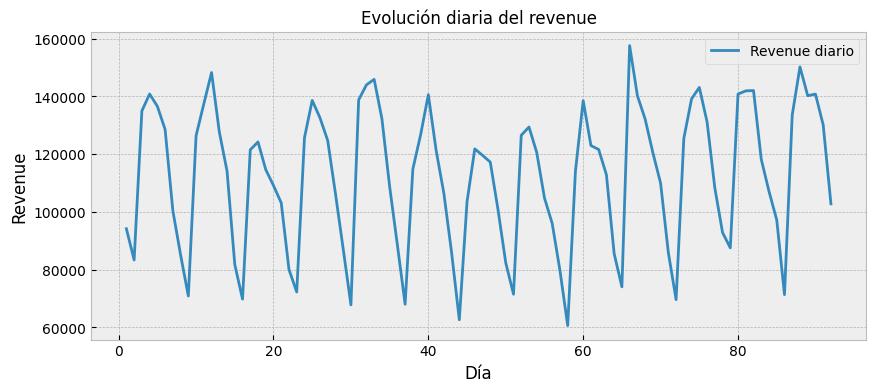

In [ ]:
revenue_diario = farmacia.groupby('day')['revenue'].sum() # Construimos una variable que sume el revenue diario.
mpl.style.use('bmh')
fig, ax = plt.subplots(figsize=(10 , 4))
ax.plot(revenue_diario, label ='Revenue diario') #pasamos la suma del revenue diario que construimos como variable a graficar
ax.set_title('Evolución diaria del revenue', fontsize='12')
ax.set_xlabel('Día', fontsize = '12')
ax.set_ylabel('Revenue', fontsize='12')
ax.legend(fontsize='10')
fig.show();

In [ ]:
#Creamos un diccionario de días de la semana,

dias = {1: 'Lunes', 2: 'Martes', 3: 'Miercoles', 4: 'Jueves', 5: 'Viernes', 6: 'Sabado', 7: 'Domingo'}

#Vinculamos el diccionario con la variable 'día' en el dataset, que tiene variables numéricas
X['dia_semana'] = X['day'].map(dias)

#Transformamos los días en dummy variables
dummies = pd.get_dummies(X['dia_semana'], prefix='dia')

#Agregamos las dummies a nuestro dataset original
X = pd.concat([X, dummies], axis=1)

#Eliminamos las columnas 'day' y 'dia_semana' que ya no nos son útiles
X = X.drop(['day', 'dia_semana'], axis=1)

#**Repaso de la base de datos resultante previo a la aplicación de modelos de Machine Learning**

In [ ]:
X

,price,adFlag,availability,click,basket,order,manufacturer,genericProduct,cantidad,barato,medio,caro,dia_Domingo,dia_Jueves,dia_Lunes,dia_Martes,dia_Miercoles,dia_Sabado,dia_Viernes
0,0.223145,0,2,1,0,0,255,0,0.0,False,False,True,False,False,True,False,False,False,False
1,0.223145,0,2,0,1,0,255,0,0.0,False,False,True,False,False,False,True,False,False,False
2,0.223145,0,2,1,0,0,255,0,0.0,False,False,True,False,False,False,True,False,False,False
3,0.223145,0,2,1,0,0,255,0,0.0,False,False,True,False,True,False,False,False,False,False
4,0.223145,0,2,0,1,0,255,0,0.0,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,-0.582841,0,2,0,0,1,753,0,4.0,True,False,False,False,False,False,False,False,False,False
2755999,-0.061666,0,2,1,0,0,811,0,0.0,False,True,False,False,False,False,False,False,False,False
2756000,-0.805992,0,2,1,0,0,61,0,0.0,True,False,False,False,False,False,False,False,False,False
2756001,-0.666523,0,2,1,0,0,811,0,0.0,True,False,False,False,False,False,False,False,False,False


In [ ]:
X.dtypes

price             float64
adFlag              int64
availability        int64
click               int64
basket              int64
order               int64
manufacturer        int64
genericProduct      int64
cantidad          float64
barato               bool
medio                bool
caro                 bool
dia_Domingo          bool
dia_Jueves           bool
dia_Lunes            bool
dia_Martes           bool
dia_Miercoles        bool
dia_Sabado           bool
dia_Viernes          bool
dtype: object

In [ ]:
X.shape

(2756003, 19)

Nótese como, gracias al tratamiento de datos que se propuso, no perdemos datos, seguimos con 2.75 millones de observaciones. Lo que cambió sustancialente es la cantidad y tipo de features, que funcionarán como variables explicativas.

In [ ]:
y.describe() #El revenue ha sido re-escalado, por eso las medias y desvíos estandar no coinciden ya con lo que vimos en el EDA

count    2.756003e+06
mean     7.992308e-17
std      1.000000e+00
min     -3.663357e-01
25%     -3.663357e-01
50%     -3.663357e-01
75%     -1.778442e-01
max      8.633002e+01
Name: revenue, dtype: float64

#**Regresión Lineal**

El primer modelo propuesto va ser la regresión lineal simple, que, como veremos, tiene escasa potencia predictiva.

##**División del dataset en test y training**

Como vamos a estar trabajando con varios modelos, vamos a generar datasets específicos para cada modelo, los vectores siguen siendo X e Y, simplemente los idenfiticamos con un nombre que haga referencia al modelo para facilitar la legibilidad del notebook.

In [ ]:
X_rlineal=X
y_rlineal=y

X_train_rlineal, x_test_rlineal, y_train_rlineal, y_test_rlineal = train_test_split(X_rlineal, y_rlineal, test_size=0.2)

###**Busqueda de las variables óptimas (Forward Selection)**



In [ ]:
!pip install mlxtend --upgrade # instalamos mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.5 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.22.0
    Uninstalling mlxtend-0.22.0:
      Successfully uninstalled mlxtend-0.22.0


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
regresion_lineal = LinearRegression()

#Instanciamos SFS, pasamos como parametro nuestro modelo, el criterio a optimizar es r2.

sfs = SFS(LinearRegression(),
          k_features=11,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 0)

In [ ]:
sfs = sfs.fit(X_train_rlineal, y_train_rlineal)
sfs.k_feature_names_

('price',
 'availability',
 'click',
 'order',
 'manufacturer',
 'genericProduct',
 'cantidad',
 'barato',
 'medio',
 'dia_Martes',
 'dia_Sabado')

Nos quedamos entonces con los regresores indicados por la Forward Selection:



In [ ]:
X_rlineal=X_rlineal.drop(['basket', 'manufacturer','dia_Domingo', 'dia_Lunes','dia_Jueves','dia_Viernes'  ], axis=1)
y_rlineal=y

X_train_rlineal, x_test_rlineal, y_train_rlineal, y_test_rlineal = train_test_split(X_rlineal, y_rlineal, test_size=0.2)

##**Instanciación y estimación de la regresión lineal**

In [ ]:
regresion_lineal=LinearRegression()

In [ ]:
regresion_lineal.fit(X_train_rlineal, y_train_rlineal)

LinearRegression()

In [ ]:
print("Coeficientes del modelo lineal\n-------------------------------\n")
coeficientes_rlineal = pd.DataFrame({'Regresor': X_train_rlineal.columns, 'Coeficiente': regresion_lineal.coef_})
print(coeficientes_rlineal.to_string(index=False))


Coeficientes del modelo lineal
-------------------------------

      Regresor   Coeficiente
         price  2.198476e-01
        adFlag -2.208699e-03
  availability -1.758173e-02
         click -6.080327e-02
         order  1.113019e+00
genericProduct -1.165620e-01
      cantidad  2.440636e-01
        barato -1.697706e+12
         medio -1.697706e+12
          caro -1.697706e+12
    dia_Martes -1.698139e-02
 dia_Miercoles -1.477091e-02
    dia_Sabado -1.726224e-02


###**Valores predichos por el modelo lineal**

In [ ]:
y_pred_rlineal = regresion_lineal.predict(x_test_rlineal)

valores_rlineal = pd.DataFrame({'Valor Real': y_test_rlineal, 'Valor predicho': y_pred_rlineal})
valores_rlineal

,Valor Real,Valor predicho
1216772,-0.366336,-0.415527
428627,-0.163195,0.850830
859468,0.329032,0.925537
1896056,0.518500,0.974121
767261,-0.366336,-0.643311
...,...,...
2410182,-0.366336,-0.641113
2463175,-0.366336,-0.239746
1209381,-0.366336,-0.627930
2509299,-0.366336,-0.165039


In [ ]:
error_medio_rlineal=metrics.mean_absolute_error(y_test_rlineal, y_pred_rlineal)
error_cuadratico_medio_rlineal=metrics.mean_squared_error(y_test_rlineal, y_pred_rlineal)
raiz_error_cuadratico_rlineal=np.sqrt(metrics.mean_squared_error(y_test_rlineal, y_pred_rlineal))
r2_rlineal=regresion_lineal.score(x_test_rlineal, y_test_rlineal)

print(f'Error medio absoluto:, {error_medio_rlineal:.2f}')
print(f'Error cuadrático medio:, {error_cuadratico_medio_rlineal:.2f}')
print(f'Raíz del error cuadratico medio:, {raiz_error_cuadratico_rlineal:.2f}')
print(f"R_cuadrado del modelo lineal:, {r2_rlineal:.3f}")


Error medio absoluto:, 0.35
Error cuadrático medio:, 0.49
Raíz del error cuadratico medio:, 0.70
R_cuadrado del modelo lineal:, 0.513


Como vemos, el r cuadrado del modelo lineal es de apenas 0.51, lo cual habla de una escasa capacidad predictiva.


###**Cross Validation del modelo de regresión lineal**

In [ ]:
n_splits = 5  # numero de estratos

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42) #instanciamos el Kfold

r2_scores = cross_val_score(regresion_lineal, X_rlineal, y_rlineal, scoring='r2', cv=kfold) #Aplicamos el cross validation

# r cuadrado de cada "fold"
print("r2 de cada fold:")
for i, r2 in enumerate(r2_scores):
    print(f"Fold {i+1}: {r2}")

# Media de los r2 de los k folds que elegimos
media_r2 = np.mean(r2_scores)
print("\ Promedio de los r cuadrados de los k-folds:", media_r2)

#r2 del modelo original

print(f"r cuadrado del modelo sin cross validation: {r2_rlineal}")

r2 de cada fold:
Fold 1: 0.5068544637231577
Fold 2: 0.49837324428004115
Fold 3: 0.5181484725383771
Fold 4: 0.5081720166941293
Fold 5: 0.5110385570374374
\ Promedio de los r cuadrados de los k-folds: 0.5085173508546286
r cuadrado del modelo sin cross validation: 0.5130664346431087


La Cross Validation del modelo lineal mejora el r2, la métrica que elegimos analizar, apenas marginalmente.

###**Grafico valores predichos y reales del modelo lineal**

In [ ]:
#Agregamos el revenue, tanto predicho como real al testing set.

x_test_rlineal['revenue_predicho']=y_pred_rlineal
x_test_rlineal['revenue_real']=y_test_rlineal

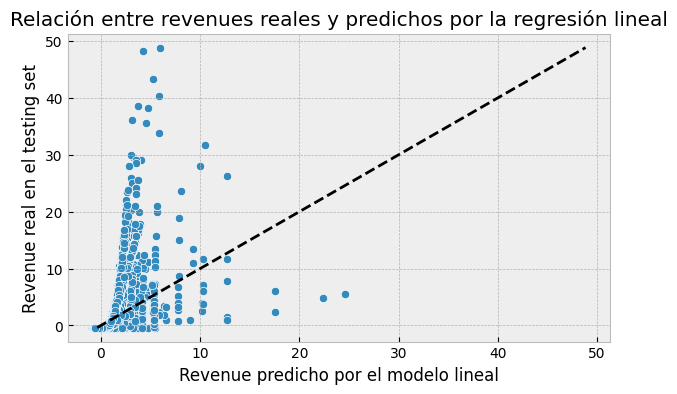

In [ ]:
plt.figure(figsize=(7, 4))
sns.scatterplot(data=x_test_rlineal, x='revenue_predicho', y='revenue_real')

#Graficamos también la línea que implicaría un ajuste perfecto
plt.plot([x_test_rlineal['revenue_real'].min(), x_test_rlineal['revenue_real'].max()], [x_test_rlineal['revenue_real'].min(), x_test_rlineal['revenue_real'].max()], 'k--', lw=2)
plt.title('Relación entre revenues reales y predichos por la regresión lineal')
plt.xlabel('Revenue predicho por el modelo lineal')
plt.ylabel('Revenue real en el testing set')
plt.show();

La dispersión en el gráfico de valores predichos y reales en el
testing set dan cuenta de la pobre capacidad predictiva del modelo lineal. Notemos como la dispersión se da a lo largo del dataset, no está concentrado en un rango de observaciones determinado.

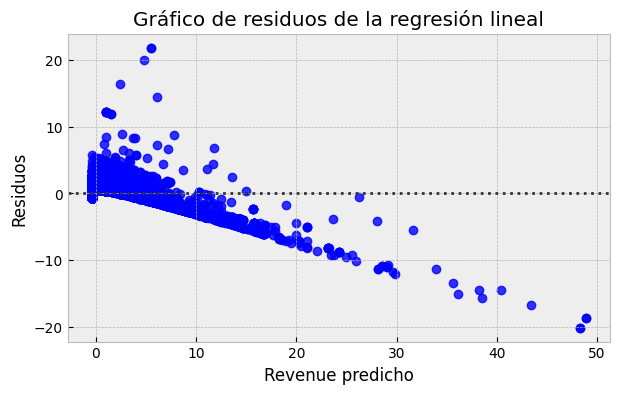

In [ ]:
#Graficamos los residuos

plt.figure(figsize=(7, 4))
sns.residplot(x='revenue_real', y='revenue_predicho', data=x_test_rlineal, color='blue')
plt.xlabel('Revenue predicho')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos de la regresión lineal')
plt.show()

In [ ]:
correlacion_revenue_rlineal = x_test_rlineal['revenue_predicho'].corr(x_test_rlineal['revenue_real'])
print(f'La correlacion entre revenue predicho y real en el modelo OLS es de {correlacion_revenue_rlineal:.3f}')

La correlacion entre revenue predicho y real en el modelo OLS es de 0.716


Dada la poca capacidad predictiva del modelo lineal, vamos a recurrir a modelos de boosting y ensamble para intentar mejorar nuestra predicción, en concreto, vamos a proponer un modelo XGBoost, LightGBM y, por el lado de ensamble, Random Forest.

#**XGBoost**

##**Instanciación del modelo XGBoost**

In [ ]:
#Creamos de nuevo nuestros training y testing set.

X_xgboost=X
y_xgboost=y

X_train_xgboost, x_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(X_xgboost, y_xgboost, test_size=0.2)

In [ ]:
modelo_xgboost = xgb.XGBRegressor()

##**Optimización de hiperparámetros usando Randomized Search**




In [ ]:
params_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5,6,7],
        'criterion':['entropy','gini']
        }

In [ ]:
#Ajustamos el modelo para buscar los mejores parámetros, nuestro criterio a maximiza va a ser el r cuadrado.

grid_cv = RandomizedSearchCV(modelo_xgboost, params_grid, scoring="r2", n_jobs=-1, cv=3)
grid_cv.fit(X_train_xgboost, y_train_xgboost)

print("Mejores parametros", grid_cv.best_params_)
print("Mejor score de CV", grid_cv.best_score_)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:26:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores parametros {'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 7, 'gamma': 0.5, 'criterion': 'gini', 'colsample_bytree': 0.6}
Mejor score de CV 0.9963150556374663


##**Ajuste y estimación del modelo XGBoost con los mejores hiperparámetros**

In [ ]:
modelo_xgboost = xgb.XGBRegressor(subsample= 1, min_child_weight= 1, max_depth= 7, gamma= 0.5, criterion="gini", colsample_bytree= 0.6)
modelo_xgboost.fit(X_train_xgboost, y_train_xgboost)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:27:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, criterion='gini', device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

##**Resultados del modelo xgboost**

In [ ]:
#Calculemos los valores de revenue predicho por el modelo
y_pred_xgboost = modelo_xgboost.predict(x_test_xgboost)

valores_xgboost = pd.DataFrame({'Valor Real': y_test_xgboost, 'Valor predicho': y_pred_xgboost})
valores_xgboost

,Valor Real,Valor predicho
2442430,-0.366336,-0.366732
966642,-0.366336,-0.365810
2361563,-0.366336,-0.363651
1138708,-0.366336,-0.366420
84768,-0.366336,-0.368654
...,...,...
1050502,-0.366336,-0.506082
1450744,-0.366336,-0.366198
460335,-0.366336,-0.364865
866546,-0.366336,-0.366677


In [ ]:
error_medio_xgboost=metrics.mean_absolute_error(y_test_xgboost, y_pred_xgboost)
error_cuadratico_medio_xgboost=metrics.mean_squared_error(y_test_xgboost, y_pred_xgboost)
raiz_error_cuadratico_xgboost=np.sqrt(metrics.mean_squared_error(y_test_xgboost, y_pred_xgboost))
r_cuadrado_xgboost = modelo_xgboost.score(x_test_xgboost, y_test_xgboost)

print(f'Error medio absoluto:, {error_medio_xgboost:.2f}')
print(f'Error cuadrático medio:, {error_cuadratico_medio_xgboost:.2f}')
print(f'Raíz del error cuadratico medio:, {raiz_error_cuadratico_xgboost:.2f}')
print(f"R_cuadrado del modelo xgboost:, {r_cuadrado_xgboost:.3f}")


Error medio absoluto:, 0.01
Error cuadrático medio:, 0.01
Raíz del error cuadratico medio:, 0.08
R_cuadrado del modelo xgboost:, 0.994


##**Graficamos los resultados del modelo XGBoost**



In [ ]:
x_test_xgboost['revenue_predicho']=y_pred_xgboost
x_test_xgboost['revenue_real']=y_test_xgboost

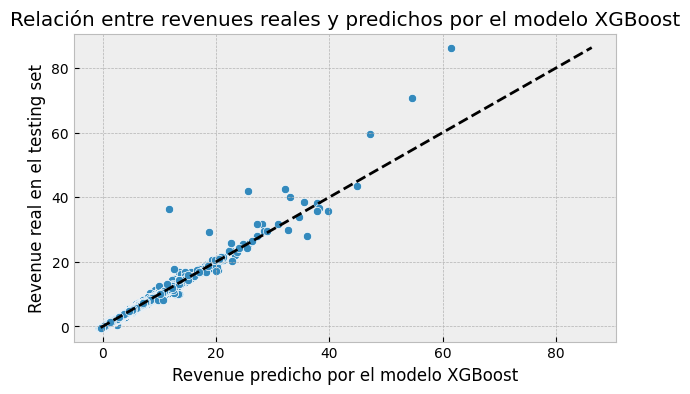

In [ ]:
plt.figure(figsize=(7, 4))
sns.scatterplot(data=x_test_xgboost, x='revenue_predicho', y='revenue_real')

plt.plot([x_test_xgboost['revenue_real'].min(), x_test_xgboost['revenue_real'].max()], [x_test_xgboost['revenue_real'].min(), x_test_xgboost['revenue_real'].max()], 'k--', lw=2)
plt.title('Relación entre revenues reales y predichos por el modelo XGBoost')
plt.xlabel('Revenue predicho por el modelo XGBoost')
plt.ylabel('Revenue real en el testing set')
plt.show();

In [ ]:
correlacion_revenue_xgboost = x_test_xgboost['revenue_predicho'].corr(x_test_xgboost['revenue_real'])
print(f'La correlacion entre revenue predicho y real en el modelo XGBoost es de {correlacion_revenue_xgboost:.3f}')

La correlacion entre revenue predicho y real en el modelo XGBoost es de 0.997


Como puede verse en el gráfico y las métricas que calculamos para evaluar la capacidad predictiva del modelo, nos encontramos con que el XGBoosting mejora muy significativamente los resultados de la regresión lineal, alcanzando una predicción casi perfecta.

##**Cross Validation del modelo xgboost**

In [ ]:
n_splits = 5  # numero de estratos

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42) #instanciamos el Kfold

r2_scores = cross_val_score(modelo_xgboost, X_xgboost, y_xgboost, scoring='r2', cv=kfold) #Aplicamos el cross validation

# r cuadrado de cada "fold"
print("r2 de cada fold:")
for i, r2 in enumerate(r2_scores):
    print(f"Fold {i+1}: {r2}")

# Media de los r2 de los k folds que elegimos
media_r2 = np.mean(r2_scores)
print("\ Promedio de los r cuadrados de los k-folds:", media_r2)

#r2 del modelo original

print(f"r cuadrado del modelo sin cross validation: {r_cuadrado_xgboost}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:28:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:28:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:28:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:29:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:29:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion" } are not used.

  warnings.warn

r2 de cada fold:
Fold 1: 0.9971229061836837
Fold 2: 0.9941479436857795
Fold 3: 0.9972399732833985
Fold 4: 0.9962097524028842
Fold 5: 0.9962860779220567
\ Promedio de los r cuadrados de los k-folds: 0.9962013306955606
r cuadrado del modelo sin cross validation: 0.9943189690671874


El Cross-Validation del modelo XGBoost con 5 folds mejora algo la capacidad predictiva, medida a través del r cuadrado, pero recordemos que ya habíamos alcanzado un nivel muy elevado de accuracy en las predicciones.

#**LightGBM**

Nuestro segundo modelo de boostig es LigthGBM, veremos que los resultados son muy similares al XGBoost, de hecho, el r2 es ligeramente más elevado, independiente de la forma específica que toma cada modelo.

In [ ]:
X_lgbm=X
y_lgbm=y

X_train_lgbm, x_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_lgbm, y_lgbm, test_size=0.2)

##**Optimización de hiperparámetros del modelo LightGBM**

In [ ]:
modelo_lgbm=lgb.LGBMRegressor()

from scipy.stats import randint as sp_randint


param_dist = {
    'n_estimators': sp_randint(50, 500),
    'max_depth': sp_randint(2, 15),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'num_leaves': sp_randint(20, 100),
    'min_child_samples': sp_randint(1, 20)
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=modelo_lgbm,
    param_distributions=param_dist,
    n_iter=10,  # Número de parametros del muestreo
    scoring='r2',  # Nuevamente el r cuadrado es nuestra métrica de evaluación
    cv=5,  # Cross-Validation Folds
    verbose=1,
    random_state=42,
    n_jobs=-1  )#Uso del CPU

In [ ]:
random_search.fit(X_train_lgbm, y_train_lgbm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.277305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 2204802, number of used features: 19
[LightGBM] [Info] Start training from score 0.000102


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e776c32a2c0>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e776def6ec0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e770bd72ef0>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e776c32a6b0>},
                   random_state=42, scoring='r2', verbose=1)

In [ ]:
print("Mejores Parametros para Light GBM:", random_search.best_params_)
print("Mejor score (r2):", -random_search.best_score_)

Mejores Parametros para Light GBM: {'learning_rate': 0.1, 'max_depth': 13, 'min_child_samples': 3, 'n_estimators': 356, 'num_leaves': 26}
Mejor score (r2): -0.9974294588893831


##**Estimación del modelo LightGBM**

In [ ]:
modelo_lgbm=lgb.LGBMRegressor(learning_rate= 0.1, max_depth= 13, min_child_samples= 3, n_estimators= 356, num_leaves= 26)
modelo_lgbm.fit(X_train_lgbm, y_train_lgbm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.579810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 2204802, number of used features: 19
[LightGBM] [Info] Start training from score 0.000102


LGBMRegressor(max_depth=13, min_child_samples=3, n_estimators=356,
              num_leaves=26)

##**Resultados del modelo LightGBM**

In [ ]:
#Valores predichos por el LigthGBM

y_pred_lgbm = modelo_lgbm.predict(x_test_lgbm)

valores_lgbm = pd.DataFrame({'Valor Real': y_test_lgbm, 'Valor predicho': y_pred_lgbm})
valores_lgbm

,Valor Real,Valor predicho
1660969,-0.366336,-0.366236
491204,1.985414,1.998057
2295414,-0.366336,-0.366214
2387722,-0.366336,-0.366298
1540418,-0.366336,-0.366341
...,...,...
2130731,-0.366336,-0.366286
1499027,2.643670,2.676700
402974,-0.366336,-0.366274
1216905,-0.366336,-0.366271


In [ ]:
error_medio_lgbm=metrics.mean_absolute_error(y_test_lgbm, y_pred_lgbm)
error_cuadratico_medio_lgbm=metrics.mean_squared_error(y_test_lgbm, y_pred_lgbm)
raiz_error_cuadratico_lgbm=np.sqrt(metrics.mean_squared_error(y_test_lgbm, y_pred_lgbm))
r_cuadrado_lgbm = modelo_lgbm.score(x_test_lgbm, y_test_lgbm)

print(f'Error medio absoluto:, {error_medio_lgbm:.2f}')
print(f'Error cuadrático medio:, {error_cuadratico_medio_lgbm:.2f}')
print(f'Raíz del error cuadratico medio:, {raiz_error_cuadratico_lgbm:.2f}')
print(f"R_cuadrado del modelo lgbm:, {r_cuadrado_lgbm:.3f}")


Error medio absoluto:, 0.00
Error cuadrático medio:, 0.00
Raíz del error cuadratico medio:, 0.05
R_cuadrado del modelo lgbm:, 0.998


##**Gráfico de los resultados del modelo LightGBM**

In [ ]:
x_test_lgbm['revenue_predicho']=y_pred_lgbm
x_test_lgbm['revenue_real']=y_test_lgbm

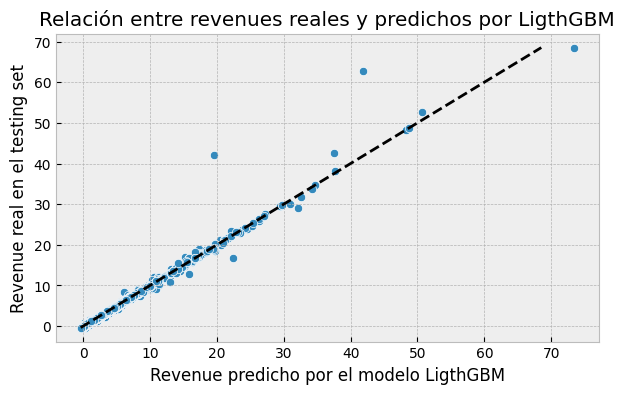

In [ ]:
plt.figure(figsize=(7, 4))
sns.scatterplot(data=x_test_lgbm, x='revenue_predicho', y='revenue_real')

plt.plot([x_test_lgbm['revenue_real'].min(), x_test_lgbm['revenue_real'].max()], [x_test_lgbm['revenue_real'].min(), x_test_lgbm['revenue_real'].max()], 'k--', lw=2)
plt.title('Relación entre revenues reales y predichos por LigthGBM')
plt.xlabel('Revenue predicho por el modelo LigthGBM')
plt.ylabel('Revenue real en el testing set')
plt.show();

In [ ]:
correlacion_revenue_lgbm = x_test_xgboost['revenue_predicho'].corr(x_test_xgboost['revenue_real'])
print(f'La correlacion entre revenue predicho y real en el modelo XGBoost es de {correlacion_revenue_xgboost:.3f}')

La correlacion entre revenue predicho y real en el modelo XGBoost es de 0.997


##**Cross Validation del Modelo LigthGBM**

In [ ]:
n_splits = 5  # numero de estratos

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42) #instanciamos el Kfold

r2_scores = cross_val_score(modelo_lgbm, X_lgbm, y_lgbm, scoring='r2', cv=kfold) #Aplicamos el cross validation

# r cuadrado de cada "fold"
print("r2 de cada fold:")
for i, r2 in enumerate(r2_scores):
    print(f"Fold {i+1}: {r2}")

# Media de los r2 de los k folds que elegimos
media_r2 = np.mean(r2_scores)
print("\ Promedio de los r cuadrados de los k-folds:", media_r2)

#r2 del modelo original

print(f"r cuadrado del modelo sin cross validation: {r_cuadrado_lgbm}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.229635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 2204802, number of used features: 19
[LightGBM] [Info] Start training from score 0.000160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.243943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 2204802, number of used features: 19
[LightGBM] [Info] Start training from score 0.000089
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.229341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

Nuevamente el cross validation mejora los resultados del modelo, pero, dada la elevada efectividad del modelo de base, esta mejora es cuantitativamente marginal.

#**Random Forest**

In [ ]:
#Generamos los vectores X e Y

X_rforest=X
y_rforest=y

X_train_rforest, x_test_rforest, y_train_rforest, y_test_rforest = train_test_split(X_rforest, y_rforest, test_size=0.2)

In [ ]:
random_forest=RandomForestRegressor(random_state=42)

##**Optimización de Hiperparámetros del Random Forest**

In [ ]:
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(1, 20),  # Numero de arboles que vamos a testear
    'max_features': ['auto', 'sqrt', 'log2'],  # Features a considerar en cada split
    'bootstrap': [True, False]  # Método de selección muestral para el entrenamiento de cada arbol

}

In [ ]:
random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_dist, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train_rforest, y_train_rforest)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e770bd96320>},
                   random_state=42, verbose=2)

In [ ]:
print("Mejores Parametros para Random Forest:", random_search.best_params_)


Mejores Parametros para Random Forest: {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 15}


##**Estimación del Random Forest con los mejores parámetros**

In [ ]:
random_forest=RandomForestRegressor(random_state=42, bootstrap= True, max_features= 'auto', n_estimators= 15)
random_forest.fit(X_train_rforest, y_train_rforest)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_features='auto', n_estimators=15, random_state=42)

##**Resultados del Random Forest**

In [ ]:
#Valores predichos

y_pred_rforest = random_forest.predict(x_test_rforest)

valores_rforest = pd.DataFrame({'Valor Real': y_test_rforest, 'Valor predicho': y_pred_rforest})
valores_rforest

,Valor Real,Valor predicho
2591980,0.745081,0.745081
2682760,-0.366336,-0.366336
1850449,-0.366336,-0.366336
448095,-0.366336,-0.366336
1851836,-0.366336,-0.366336
...,...,...
2175770,-0.366336,-0.366336
1407726,2.207111,2.207111
1206907,2.523543,2.523543
2183407,1.347668,1.347668


In [ ]:
error_medio_rforest=metrics.mean_absolute_error(y_test_rforest, y_pred_rforest)
error_cuadratico_medio_rforest=metrics.mean_squared_error(y_test_rforest, y_pred_rforest)
raiz_error_cuadratico_rforest=np.sqrt(metrics.mean_squared_error(y_test_rforest, y_pred_rforest))
r_cuadrado_rforest = random_forest.score(x_test_rforest, y_test_rforest)

print(f'Error medio absoluto:, {error_medio_rforest:.2f}')
print(f'Error cuadrático medio:, {error_cuadratico_medio_rforest:.2f}')
print(f'Raíz del error cuadratico medio:, {raiz_error_cuadratico_rforest:.2f}')
print(f"R_cuadrado del modelo rforest:, {r_cuadrado_rforest:.3f}")


Error medio absoluto:, 0.00
Error cuadrático medio:, 0.00
Raíz del error cuadratico medio:, 0.07
R_cuadrado del modelo rforest:, 0.996


In [ ]:
x_test_rforest['revenue_predicho']=y_pred_rforest
x_test_rforest['revenue_real']=y_test_rforest

In [ ]:
correlacion_revenue_rforest = x_test_rforest['revenue_predicho'].corr(x_test_rforest['revenue_real'])
print(f'La correlacion entre revenue predicho y real del Random Forest es de {correlacion_revenue_rforest:.3f}')

La correlacion entre revenue predicho y real del Random Forest es de 0.998


##**Gráfico de los resultados del Random Forest**

In [ ]:
x_test_rforest['revenue_predicho']=y_pred_rforest
x_test_rforest['revenue_real']=y_test_rforest

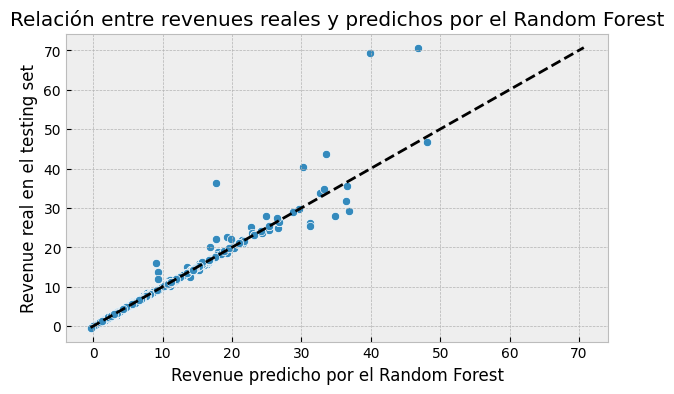

In [ ]:
plt.figure(figsize=(7, 4))
sns.scatterplot(data=x_test_rforest, x='revenue_predicho', y='revenue_real')

plt.plot([x_test_rforest['revenue_real'].min(), x_test_rforest['revenue_real'].max()], [x_test_rforest['revenue_real'].min(), x_test_rforest['revenue_real'].max()], 'k--', lw=2)
plt.title('Relación entre revenues reales y predichos por el Random Forest')
plt.xlabel('Revenue predicho por el Random Forest')
plt.ylabel('Revenue real en el testing set')
plt.show();

###**Cross Validation del modelo de Random Forest**

In [ ]:
n_splits = 5  # numero de estratos

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42) #instanciamos el Kfold

r2_scores = cross_val_score(random_forest, X_rforest, y_rforest, scoring='r2', cv=kfold) #Aplicamos el cross validation

# r cuadrado de cada "fold"
print("r2 de cada fold:")
for i, r2 in enumerate(r2_scores):
    print(f"Fold {i+1}: {r2}")

# Media de los r2 de los k folds que elegimos
media_r2 = np.mean(r2_scores)
print("\ Promedio de los r cuadrados de los k-folds:", media_r2)

#r2 del modelo original

print(f"r cuadrado del modelo sin cross validation: {r_cuadrado_rforest}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

r2 de cada fold:
Fold 1: 0.9988086428032562
Fold 2: 0.9921089080061692
Fold 3: 0.9992893098437479
Fold 4: 0.998348058680552
Fold 5: 0.998755740287987
\ Promedio de los r cuadrados de los k-folds: 0.9974621319243425
r cuadrado del modelo sin cross validation: 0.9956921025783311


#**Resumen y Conclusiones de los modelos de regresión**

In [ ]:
#Armamos un dataframe con las medidas de evaluación de las regresiones

medidas = {
    'Error Medio': [error_medio_rlineal, error_medio_xgboost, error_medio_lgbm, error_medio_rforest],
    'Error Cuadrático Medio': [error_cuadratico_medio_rlineal, error_cuadratico_medio_xgboost, error_cuadratico_medio_lgbm, error_cuadratico_medio_rforest],
    'Raíz del Error Cuadrático': [raiz_error_cuadratico_rlineal, raiz_error_cuadratico_xgboost, raiz_error_cuadratico_lgbm, raiz_error_cuadratico_rforest],
    'R cuadrado': [r2_rlineal, r_cuadrado_xgboost, r_cuadrado_lgbm, r_cuadrado_rforest],
    'Correlación con Revenue': [correlacion_revenue_rlineal, correlacion_revenue_xgboost, correlacion_revenue_lgbm,correlacion_revenue_rforest ]
}

tabla_medidas = pd.DataFrame(medidas, index=["Modelo Lineal", "XGBoost", "Light GBM", "Random Forest"])

print(tabla_medidas)

               Error Medio  Error Cuadrático Medio  Raíz del Error Cuadrático  \
Modelo Lineal     0.349186                0.486599                   0.697566   
XGBoost           0.010996                0.005819                   0.076284   
Light GBM         0.002408                0.002167                   0.046550   
Random Forest     0.000398                0.004307                   0.065626   

               R cuadrado  Correlación con Revenue  
Modelo Lineal    0.513066                 0.716392  
XGBoost          0.994319                 0.997186  
Light GBM        0.997864                 0.997186  
Random Forest    0.995692                 0.997856  


La tabla agrega los resultados de los distintos modelos, como vemos, partiendo de un modelo lineal poco adecuado, mejoramos sustancialmente las métricas aplicando métodos de ensamble y boosting, la correlación del revenue predicho con el revenue real en el testing set es del 99.7%,
En particular, el modelo con el menor error cuadrático medio y mejor r2 es Light GBM, pero los 3 modelos de boosting y/o ensamble se adaptan adecuadamente a nuestra estructura de datos

#**Apéndice: Aplicación de un modelo de clasificación para predecir ventas**

Hasta ahora hemos usado las variables del dataset para predecir el revenue, que es una variable numérica continua.
Alternativamente, podemos realizar ejercicios de clasificación para predecir ventas.

La variable dependiente, en ese caso, es order, que toma el valor 1 cuando un registro representa una venta, y 0 cuando no es el caso.

Para entender el contexto comercial, supongamos que trabajamos en el departamento de Marketing, o de Ventas, donde lo que nos interesa fundamentalmente es predecir ventas, mientras que, desde el lado del departamento de finanzas o de la dirección general de la empresa, estamos interesados tanto en ventas como revenue, ganancias, etc.

Pero también podemos suponer que no tenemos la variable revenue en el dataset, es decir, imaginemos nuestro mismo dataset pero sin revenue, o que tenemos demasiados faltantes para este feature, ¿podemos extraer información relevante? La propuesta de esta sección es que sí, el dataset sigue siendo relevante para la dirección de la empresa, la predicción de ventas en sí misma es fundamental a la hora de tomar decisiones en un contexto empresarial.

##**Repaso de la variable ventas ("order") y sus relación con las restantes variables**



In [ ]:
proporcion_ventas = farmacia_re_escalada['order'].value_counts(normalize=True) * 100

print("Proporcion de observaciones que representan ventas':")
print(proporcion_ventas)

Proporcion de observaciones que representan ventas':
order
0    74.416211
1    25.583789
Name: proportion, dtype: float64


Como vemos, el 25.5% de las observaciones representan ventas

In [ ]:
print(f'Desvío estandar de los precios de productos no comprados (order==0): {desvio_precio_order_0:.2f}')
print(f'Mediana de los precios de productos comprados (order==1): {mediana_precio_order_1:.2f}')

Desvío estandar de los precios de productos no comprados (order==0): 14.18
Mediana de los precios de productos comprados (order==1): 8.75


Los productos efectivamente comprados tienen un precio algo más bajo que la mediana general (recordemos es \$9.85) de la muestra y significativamente más bajo que los productos no comprados. La dispersion sigue siendo elevada.

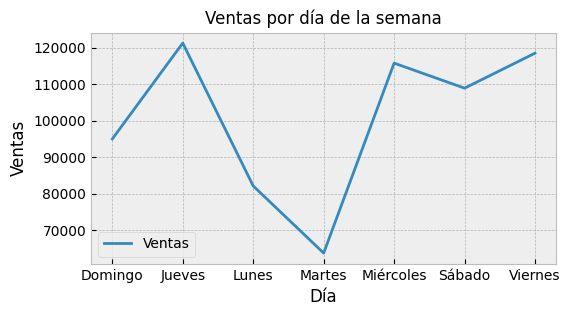

In [ ]:
ventas_diarias = farmacia_final.groupby('dia_semana')['order'].sum()
mpl.style.use('bmh')
fig, ax = plt.subplots(figsize=(6 , 3))
ax.plot(ventas_diarias, label ='Ventas')
ax.set_title('Ventas por día de la semana', fontsize='12')
ax.set_xlabel('Día', fontsize = '12')
ax.set_ylabel('Ventas', fontsize='12')
ax.legend(fontsize='10')
fig.show();

El análisis temporal es, lógicamente, idéntico al que hicimos por revenue, las ventas tienen un pico los jueves, seguido de los miercoles, con los valores mas bajos los 'martes'.

Partiendo del dataset una vez realizado el módulo de limpieza de datos primaria, previo al ajuste de escala de variables.

In [ ]:
#Proporción de genericos en las ventas

ventas_ordenadas = farmacia_final[farmacia_final['order'] == 1]
ventas_genericas = ventas_ordenadas['genericProduct'].mean()
print(f"Propoción de genéricos en las ventas: {ventas_genericas:.2f}")

Propoción de genéricos en las ventas: 0.15


El 15% de las ventas son genéricos

In [ ]:
ventas_ordenadas = farmacia_final[farmacia_final['order'] == 1]

proporcion_publicidad = ventas_ordenadas['adFlag'].mean()

print(f"Proporción de ventas que representan productos publicitados: {proporcion_publicidad*100:.2f}%")

Proporción de ventas que representan productos publicitados: 40.05%


##**Preparación de los vectores X e Y para adecuarlos al modelo de clasificación**

Seleccionamos nuestra variable dependiente **order** y excluimos las variables categoricas que encodeamos para no generar duplicaciones.

Tambien voy a excluir el revenue como regresor, recodemos que estamos tratando de predecir si una línea va a derivar en una venta en funcion de sus caracteristicas, y el revenue por definición es precio por cantidad vendida cuando hay ventas, entonces, el revenue tiene lugar después que un cliente decide una compra, no puede ser nunca una variable explicativa de las ventas.

Tambien eliminamos lineID como variable independiente, no tiene valor explicativo

In [ ]:
#Volvemos a generar los vectores X e Y, esta vez eliminando revenue como variable independiente y dejando order como variable dependiente.

X = farmacia_re_escalada.drop([ 'lineID', 'order' , 'group', 'content', 'unit', 'category','campaignIndex', 'pharmForm' , 'revenue' ,

'rrp', 'competitorPrice', 'unit_CM', 'unit_G',  'unit_KG' , 'unit_L' , 'unit_M' , 'unit_P' , 'unit_ST', 'campaignIndex_A' , 'unit_ML',

 'campaignIndex_B' , 'campaignIndex_C' , 'campaignIndex_D' ], axis=1)

y = farmacia_re_escalada['order']

In [ ]:
#Constatamos que sólo nos quedamos con las variables que nos interesan

X.dtypes

price             float64
day                 int64
pid                 int64
adFlag              int64
availability        int64
click               int64
basket              int64
manufacturer        int64
genericProduct      int64
salesIndex          int64
cantidad          float64
dia_semana         object
dtype: object

In [ ]:
#Volvemos a agrupar productos en "caro", "barato", "medio"

cuantiles = pd.qcut(X['price'], q=3, labels=['barato', 'medio', 'caro'])

dummies_cuantiles = pd.get_dummies(cuantiles)

# Lo concatenamos con X

nuevo_X = pd.concat([X, dummies_cuantiles], axis=1)

In [ ]:
#eliminamos la variable pid, product id, que ya no tiene sentido porque cada producto está agrupado por precio

X=nuevo_X.drop(['pid'], axis=1)

Volvemos a agrupar por día de la semana

In [ ]:
#Creamos un diccionario de días de la semana

dias = {1: 'Lunes', 2: 'Martes', 3: 'Miercoles', 4: 'Jueves', 5: 'Viernes', 6: 'Sabado', 7: 'Domingo'}

#Vinculamos el diccionario con la variable 'día' en el dataset, que tiene variables numéricas
X['dia_semana'] = X['day'].map(dias)

#Transformamos los días en dummy variables
dummies = pd.get_dummies(X['dia_semana'], prefix='dia')

#Agregamos las dummies a nuestro dataset original
X = pd.concat([X, dummies], axis=1)

#Eliminamos las columnas 'day' y 'dia_semana' que ya no nos son útiles
X = X.drop(['day', 'dia_semana'], axis=1)

In [ ]:
#Constatamos que tenemos las variables explicativas necesarias para la regresión logística.

X.dtypes

price             float64
adFlag              int64
availability        int64
click               int64
basket              int64
manufacturer        int64
genericProduct      int64
salesIndex          int64
cantidad          float64
barato               bool
medio                bool
caro                 bool
dia_Domingo          bool
dia_Jueves           bool
dia_Lunes            bool
dia_Martes           bool
dia_Miercoles        bool
dia_Sabado           bool
dia_Viernes          bool
dtype: object

##**Estimación de la regresión logística**

In [ ]:
#Generamos los subsets de train y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Selección de Hiperparámetros de la regresión logística usando Randomized Search

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'tol': [0.0001, 0.001, 0.01],
    'penalty': ['l1', 'l2'],
}

In [ ]:
reg_logistica = LogisticRegression(max_iter=2000, solver='saga') #El solver saga demostró ser computacionalmente menos intensivo en pruebas excluidasa de la versión final

grid_search = RandomizedSearchCV(estimator=reg_logistica, param_distributions=param_grid, cv=2, scoring='accuracy') #Instanciamos el gridSearch usando nuestro objeto estimador "reg_logistica", la acuracy de las predicciones es nuestro benchmark
grid_search.fit(X, y)



RandomizedSearchCV(cv=2,
                   estimator=LogisticRegression(max_iter=2000, solver='saga'),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'penalty': ['l1', 'l2'],
                                        'tol': [0.0001, 0.001, 0.01]},
                   scoring='accuracy')

In [ ]:
grid_search.best_estimator_

LogisticRegression(C=0.01, max_iter=2000, penalty='l1', solver='saga',
                   tol=0.001)

Como vemos, el GridSearch nos lleva a ajustar nuestros parametros como C=0.001, penalty = 'l1', esto es un resultado relevante porque, como indica el manual de scikit learn, el parámetro por default es l2.

Además, un C bajo (como es el caso con C=0.001) es indicativo de un modelo más simple orientado a evitar el overfitting.

In [ ]:
reg_logistica = LogisticRegression(max_iter=2000, solver='saga', C=0.01, tol=0.001, penalty='l1')

reg_logistica.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=2000, penalty='l1', solver='saga',
                   tol=0.001)

##**Evaluación de la efectividad del modelo de regresión logística**

In [ ]:
y_pred = reg_logistica.predict(X_test) # utilizamos el modelo para predecir los valores en el testing set.

###**Accuracy**

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo:", f'{accuracy:.3f}')

Accuracy del modelo: 1.000


Hemos logrado un accuracy del 100%, esto indica que nuestra estructura de datos se adapta muy bien a la predicción de ventas (recordemos, variabe order, que toma el valor 1 cuando se trata de ventas y 0 cuando no), y, con algunos ajustes de Feature Engineering, logramos un modelo de muy alta potencia predictiva.

###**Matriz de confusión**

In [ ]:
matriz_confusion = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n\n", matriz_confusion)

Matriz de confusión:

 [[410309      0]
 [     0 140892]]


La matriz de confusión nos muestra que logramos predecir correctamente la totalidad de las ventas (140.842, segunda columna) como las observaciones que no son ventas (410.309), todo lo cual es consistente con el accuracy del 100% econtrado en el apartado anterior.

###**Precision Score**

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

1.0

Que el precision score tenga un valor de 1 es una consecuencia directa del accuracy score de 1, y la matriz de confusión que obtuvimos, sin falsos positivos, dada la fórmula del precision score, es lógico que este resulte en un valor de 1.

###**F1 Score**

Dado que logramos un accuracy del 100% con el modelo, es lógico que el precision score sea de 1, recordemos que la fórmula es:

Precisión= Verdadero Positivo / (Verdadero positivo + Falso Positivo)

En nuestro caso = 410309/(410309 + 0) = 1

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

1.0

##**Clasification Score**

La lectura del Classification Report nos indica que:

>  La precisión y el accuracy es del 100%
> Dado que la precisión (accuracy) y el recall son 1, el F1 score también resulta en un valor de 1.*italicized text*

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    410309
           1       1.00      1.00      1.00    140892

    accuracy                           1.00    551201
   macro avg       1.00      1.00      1.00    551201
weighted avg       1.00      1.00      1.00    551201



##**Curva AUC ROC**

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_score1 = reg_logistica.predict_proba(X_test)[:,1]
y_score1

array([0.98805978, 0.00148254, 0.98899962, ..., 0.00122331, 0.001462  ,
       0.00142805])

In [ ]:
# Calculo de tasas
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

In [ ]:
print('RoC - AUC Score: ', roc_auc_score(y_test, y_score1))

RoC - AUC Score:  1.0


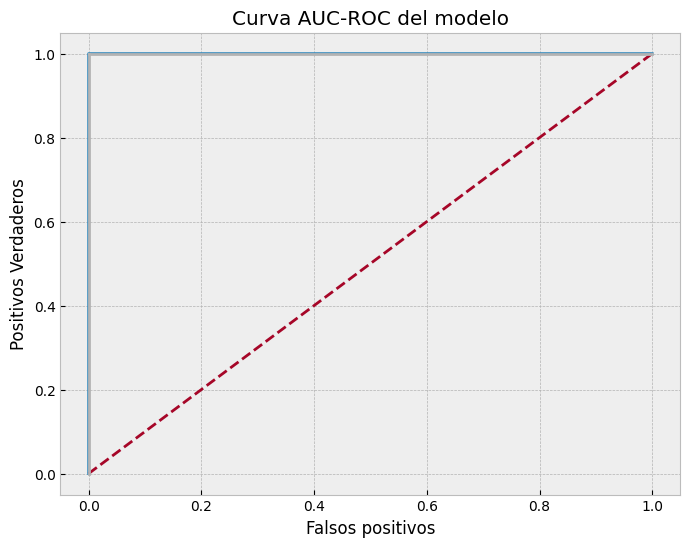

In [ ]:
plt.subplots(1, figsize=(8,6))
plt.title('Curva AUC-ROC del modelo')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Positivos Verdaderos')
plt.xlabel('Falsos positivos')
plt.show()

Dado el accuracy de 100% que alcanzamos con el modelo de regresión logística como se ha parametrizado, la curva AUC ROC nos muestra un ajuste perfecto.

#**Conclusión general del trabajo**

> El objetivo del trabajo ha sido predecir el revenue, es decir, el ingreso por ventas que obtiene la farmacia, aplicando modelos de regresión.

> Nuestro Dataset requiere una ingeniería de datos fundamentalmente relacionada con missing values en 4 de las 20 variables originales y el tratamiento de la dimensión temporal el número de producto, que podría introducir variabilidad espuria en los resultados.

> El modelo lineal no arroja resultados satisfactorios en las medidas de evaluación, por ejemplo, el r cuadrado es de solo 0.51, incluso después de seleccionar los mejores features aplicando Forward Selection.

> En cambio, obtenemos buenos resultados con modelos de ensamble (Random Forest) y Boosting. En todos esos casos, el r cuadrado supera el valor de 0.99, y otras medidas de evaluación de regresiones también son positivas, así como la correlacion entre valores predichos por los modelos y reales en el testing set.

> Si nos centráramos en la predicción de ventas, donde tenemos una variable categórica que denota las mismas, un modeo de regresión logística previa optimización de hiperparámetros arroja un accuracy total.

> Todo esto muestra que nuestras variables predicticas son adecuadas a la hora de predecir el revenue.

> Pensando en el contexto comercial de la empresa, y sabiendo que tenemos variables predictoras adecuadas, podemos recomendar a la dirección de la farmacia que,

>> La dimensión temporal importa. Sabiendo esto, se podría estructurar una política de descuentos sabiendo cuáles son los días de mayores ventas.

>> El precio también es importante, ya que la curva de demanda tiene pendiente negativa.

>>La publicidad parece tener un efecto en las ventas y el revenue. En conjunción con el conocimiento sobre la estacionalidad al interior de las semanas y los precios, podemos recomendar cuando incrementar los esfuerzos publicitarios.

>>Nuestras ventas exhiben un elevado grado de concentración a nivel de producto y fabricante. Enfocandose en la negociación con los proveedores más importantes, podría mejorarse el revenue consiguiendo mejores descuentos con los proveedores que sabemos representan la mayor proporción de ingresos, lo cual nos permitiría mejorar nuestros precios, que, como vimos, son una variable relevante a la hora de explicar ventas.

